In [43]:
import numpy as np
import matplotlib.pyplot as plt


# from hnc_custom_screeningOZ_multiscale import  HNC_solver
from hnc import  HNC_solver
from qsps import *

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [63]:
N_bins, R_max = 1000, 10

In [64]:
def run_hnc(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3, c_s_r_guess=None , which_Tij='thermal', method='best'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = qsp.Tij
    masses= qsp.mij
#     hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses , tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)

    hnc1 = HNC_solver(N_species, Gamma, rhos, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), qsp.βvei(hnc1.r_array)],
                            [qsp.βvei(hnc1.r_array), qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    if c_s_r_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_s_r_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
                    hnc1.c_s_r_matrix[i,j] = c_s_r_guess[i,j]
                    hnc1.c_s_k_matrix[i,j] = hnc1.FT_r_2_k(c_s_r_guess[i,j])
                    hnc1.c_r_matrix[i,j] = hnc1.c_s_k_matrix[i,j] - hnc1.βu_l_k_matrix[i,j]

    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)

    return hnc1, qsp

In [65]:
def run_hnc_one_ion(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best', which_Tij='thermal' ):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
#     hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)

    hnc1 = HNC_solver(N_species, Gamma,rho, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp

def run_hnc_TF(n_in_per_cc, T, Z, A, Zstar,κ = 1, num_iterations=1e3, alpha = 1e-3,method='best', which_Tij='thermal' ):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
#     hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)

    hnc1 = HNC_solver(N_species, Gamma,rho, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[ qsp.Γii/hnc1.r_array *np.exp(-κ*hnc1.r_array)  ]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp

def run_hnc_one_electron(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best' , which_Tij='thermal'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["e"] 
    kappa = 1
    rho = np.array([  Zstar*3/(4*np.pi)])
    temps = np.array([[qsp.Te_c]])
    masses= np.array([[m_e]])
#     hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)

    hnc1 = HNC_solver(N_species, Gamma,rho, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp



# Carbon

In [78]:
def get_κ(Zstar, ri, Ti, E_F):
    kTF = np.sqrt(  4*π* Zstar*QSP_HNC.n_from_rs(ri)  /np.sqrt(Ti**2 + (2/3*E_F)**2)  )
    return kTF*ri


In [80]:
κ = get_κ(Zstar, ri, Ti, carbonqsp.E_F)
print("κ = ", κ)
carbon_TF, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=κ, which_Tij='geometric', method='fixed', alpha=1e0, num_iterations=1e3)

κ =  2.2766518956820994
Λee = 0.299
Λei = 0.212
Γii=37.137, Γie=-1.539, Γee=0.382 
r_i=1.360
r_e=0.857
θ  =1.26e-01
0: Err in c_r: 1.23e+02, OZ: 6.78e-16, HNC: 2.99e-16, tot: 0.17
1: Err in c_r: 1.47e+01, OZ: 9.46e-16, HNC: 2.14e-16, tot: 0.18
2: Err in c_r: 5.08e+00, OZ: 4.19e-16, HNC: 1.81e-16, tot: 0.21
3: Err in c_r: 2.67e+00, OZ: 3.72e-16, HNC: 1.95e-16, tot: 0.23
4: Err in c_r: 1.69e+00, OZ: 2.29e-16, HNC: 1.34e-16, tot: 0.24
5: Err in c_r: 1.17e+00, OZ: 2.91e-16, HNC: 1.02e-16, tot: 0.25
6: Err in c_r: 8.44e-01, OZ: 1.68e-16, HNC: 8.75e-17, tot: 0.26
7: Err in c_r: 6.22e-01, OZ: 1.41e-16, HNC: 7.56e-17, tot: 0.27
8: Err in c_r: 4.66e-01, OZ: 1.58e-16, HNC: 6.47e-17, tot: 0.28
9: Err in c_r: 3.52e-01, OZ: 1.05e-16, HNC: 5.02e-17, tot: 0.29
10: Err in c_r: 2.68e-01, OZ: 1.46e-16, HNC: 5.07e-17, tot: 0.31
11: Err in c_r: 2.05e-01, OZ: 1.38e-16, HNC: 4.72e-17, tot: 0.32
12: Err in c_r: 1.58e-01, OZ: 1.38e-16, HNC: 4.54e-17, tot: 0.33
13: Err in c_r: 1.21e-01, OZ: 2.62e-16, HNC: 4.12

In [128]:
carbonqsp.Γii,carbonqsp.Γei

(37.13661234349751, -1.5392328481395159)

In [75]:
fake_κ=0.6
carbon_TF_fake, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=fake_κ, which_Tij='geometric', method='fixed', alpha=1e0, num_iterations=1e3)

Λee = 0.299
Λei = 0.212
Γii=37.137, Γie=-1.539, Γee=0.382 
r_i=1.360
r_e=0.857
θ  =1.26e-01
0: Err in c_r: 1.23e+02, OZ: 1.74e-15, HNC: 6.36e-16, tot: 0.17
1: Err in c_r: 1.52e+01, OZ: 2.21e-15, HNC: 7.36e-16, tot: 0.18
2: Err in c_r: 5.51e+00, OZ: 1.94e-15, HNC: 8.04e-16, tot: 0.21
3: Err in c_r: 3.05e+00, OZ: 2.95e-15, HNC: 8.13e-16, tot: 0.25
4: Err in c_r: 2.04e+00, OZ: 1.41e-15, HNC: 6.51e-16, tot: 0.26
5: Err in c_r: 1.50e+00, OZ: 1.47e-15, HNC: 5.02e-16, tot: 0.27
6: Err in c_r: 1.16e+00, OZ: 2.23e-15, HNC: 5.59e-16, tot: 0.28
7: Err in c_r: 9.22e-01, OZ: 1.69e-15, HNC: 5.57e-16, tot: 0.28
8: Err in c_r: 7.47e-01, OZ: 1.45e-15, HNC: 4.55e-16, tot: 0.29
9: Err in c_r: 6.15e-01, OZ: 1.61e-15, HNC: 4.39e-16, tot: 0.30
10: Err in c_r: 5.12e-01, OZ: 1.19e-15, HNC: 4.24e-16, tot: 0.31
11: Err in c_r: 4.31e-01, OZ: 1.20e-15, HNC: 3.54e-16, tot: 0.32
12: Err in c_r: 3.65e-01, OZ: 1.16e-15, HNC: 3.50e-16, tot: 0.33
13: Err in c_r: 3.12e-01, OZ: 1.47e-15, HNC: 3.30e-16, tot: 0.34
14: Err 

In [126]:
ri = 1.36
ni = QSP_HNC.n_from_rs(ri)/aB**3*1e-6
Te = 8.62*eV #430.9*eV 
Ti   = 8.62*eV #430.9*eV 
Z, A = 6,12
Zstar= 4#5.758

# c_s_r_guess = np.zeros((2,2,N_bins))
# c_s_r_guess[0,0] = carbon_one_species.c_s_r_matrix

carbon, carbonqsp = run_hnc(ni, Te, Z, A, Zstar , which_Tij='geometric', method='fixed', alpha=1e-1, num_iterations=1e3)


Λee = 0.299
Λei = 0.212
Γii=37.137, Γie=-1.539, Γee=0.382 
r_i=1.360
r_e=0.857
θ  =1.26e-01
0: Err in c_r: 6.15e+00, OZ: 2.87e-01, HNC: 9.04e+00, tot: 0.35
1: Err in c_r: 5.61e+00, OZ: 2.83e-01, HNC: 5.16e+00, tot: 0.34
2: Err in c_r: 5.12e+00, OZ: 2.79e-01, HNC: 3.38e+00, tot: 0.34
3: Err in c_r: 4.68e+00, OZ: 2.76e-01, HNC: 2.44e+00, tot: 0.33
4: Err in c_r: 4.27e+00, OZ: 2.72e-01, HNC: 1.91e+00, tot: 0.33
5: Err in c_r: 3.89e+00, OZ: 2.69e-01, HNC: 1.58e+00, tot: 0.33
6: Err in c_r: 3.55e+00, OZ: 2.65e-01, HNC: 1.38e+00, tot: 0.33
7: Err in c_r: 3.24e+00, OZ: 2.62e-01, HNC: 1.26e+00, tot: 0.34
8: Err in c_r: 2.95e+00, OZ: 2.59e-01, HNC: 1.18e+00, tot: 0.34
9: Err in c_r: 2.70e+00, OZ: 2.56e-01, HNC: 1.14e+00, tot: 0.35
10: Err in c_r: 2.46e+00, OZ: 2.54e-01, HNC: 1.13e+00, tot: 0.35
11: Err in c_r: 2.24e+00, OZ: 2.51e-01, HNC: 1.14e+00, tot: 0.36
12: Err in c_r: 2.05e+00, OZ: 2.49e-01, HNC: 1.17e+00, tot: 0.37
13: Err in c_r: 1.87e+00, OZ: 2.46e-01, HNC: 1.21e+00, tot: 0.38
14: Err 

131: Err in c_r: 1.78e-02, OZ: 9.83e-02, HNC: 3.19e+00, tot: 1.73
132: Err in c_r: 1.75e-02, OZ: 9.73e-02, HNC: 3.12e+00, tot: 1.74
133: Err in c_r: 1.72e-02, OZ: 9.64e-02, HNC: 3.06e+00, tot: 1.74
134: Err in c_r: 1.69e-02, OZ: 9.55e-02, HNC: 2.99e+00, tot: 1.75
135: Err in c_r: 1.67e-02, OZ: 9.45e-02, HNC: 2.93e+00, tot: 1.75
136: Err in c_r: 1.64e-02, OZ: 9.36e-02, HNC: 2.87e+00, tot: 1.76
137: Err in c_r: 1.62e-02, OZ: 9.27e-02, HNC: 2.81e+00, tot: 1.76
138: Err in c_r: 1.59e-02, OZ: 9.18e-02, HNC: 2.75e+00, tot: 1.77
139: Err in c_r: 1.57e-02, OZ: 9.09e-02, HNC: 2.70e+00, tot: 1.77
140: Err in c_r: 1.54e-02, OZ: 9.00e-02, HNC: 2.64e+00, tot: 1.78
141: Err in c_r: 1.52e-02, OZ: 8.91e-02, HNC: 2.59e+00, tot: 1.78
142: Err in c_r: 1.50e-02, OZ: 8.83e-02, HNC: 2.54e+00, tot: 1.79
143: Err in c_r: 1.48e-02, OZ: 8.74e-02, HNC: 2.49e+00, tot: 1.79
144: Err in c_r: 1.45e-02, OZ: 8.65e-02, HNC: 2.44e+00, tot: 1.80
145: Err in c_r: 1.43e-02, OZ: 8.57e-02, HNC: 2.39e+00, tot: 1.80
146: Err i

257: Err in c_r: 3.16e-03, OZ: 2.57e-02, HNC: 4.09e-01, tot: 2.06
258: Err in c_r: 3.12e-03, OZ: 2.54e-02, HNC: 4.03e-01, tot: 2.06
259: Err in c_r: 3.08e-03, OZ: 2.52e-02, HNC: 3.98e-01, tot: 2.06
260: Err in c_r: 3.05e-03, OZ: 2.49e-02, HNC: 3.93e-01, tot: 2.06
261: Err in c_r: 3.01e-03, OZ: 2.46e-02, HNC: 3.87e-01, tot: 2.07
262: Err in c_r: 2.97e-03, OZ: 2.43e-02, HNC: 3.82e-01, tot: 2.07
263: Err in c_r: 2.93e-03, OZ: 2.40e-02, HNC: 3.77e-01, tot: 2.07
264: Err in c_r: 2.90e-03, OZ: 2.38e-02, HNC: 3.72e-01, tot: 2.07
265: Err in c_r: 2.86e-03, OZ: 2.35e-02, HNC: 3.68e-01, tot: 2.07
266: Err in c_r: 2.83e-03, OZ: 2.32e-02, HNC: 3.63e-01, tot: 2.07
267: Err in c_r: 2.79e-03, OZ: 2.30e-02, HNC: 3.58e-01, tot: 2.07
268: Err in c_r: 2.76e-03, OZ: 2.27e-02, HNC: 3.53e-01, tot: 2.07
269: Err in c_r: 2.72e-03, OZ: 2.25e-02, HNC: 3.49e-01, tot: 2.07
270: Err in c_r: 2.69e-03, OZ: 2.22e-02, HNC: 3.44e-01, tot: 2.07
271: Err in c_r: 2.66e-03, OZ: 2.20e-02, HNC: 3.40e-01, tot: 2.07
272: Err i

383: Err in c_r: 6.84e-04, OZ: 6.05e-03, HNC: 8.42e-02, tot: 2.13
384: Err in c_r: 6.76e-04, OZ: 5.98e-03, HNC: 8.32e-02, tot: 2.13
385: Err in c_r: 6.68e-04, OZ: 5.91e-03, HNC: 8.22e-02, tot: 2.13
386: Err in c_r: 6.60e-04, OZ: 5.84e-03, HNC: 8.12e-02, tot: 2.13
387: Err in c_r: 6.52e-04, OZ: 5.77e-03, HNC: 8.03e-02, tot: 2.13
388: Err in c_r: 6.45e-04, OZ: 5.70e-03, HNC: 7.93e-02, tot: 2.13
389: Err in c_r: 6.37e-04, OZ: 5.64e-03, HNC: 7.84e-02, tot: 2.13
390: Err in c_r: 6.29e-04, OZ: 5.57e-03, HNC: 7.74e-02, tot: 2.13
391: Err in c_r: 6.22e-04, OZ: 5.51e-03, HNC: 7.65e-02, tot: 2.13
392: Err in c_r: 6.15e-04, OZ: 5.44e-03, HNC: 7.56e-02, tot: 2.13
393: Err in c_r: 6.07e-04, OZ: 5.38e-03, HNC: 7.47e-02, tot: 2.13
394: Err in c_r: 6.00e-04, OZ: 5.32e-03, HNC: 7.38e-02, tot: 2.13
395: Err in c_r: 5.93e-04, OZ: 5.26e-03, HNC: 7.29e-02, tot: 2.13
396: Err in c_r: 5.86e-04, OZ: 5.20e-03, HNC: 7.20e-02, tot: 2.13
397: Err in c_r: 5.79e-04, OZ: 5.14e-03, HNC: 7.12e-02, tot: 2.13
398: Err i

510: Err in c_r: 1.52e-04, OZ: 1.37e-03, HNC: 1.85e-02, tot: 2.14
511: Err in c_r: 1.50e-04, OZ: 1.35e-03, HNC: 1.83e-02, tot: 2.14
512: Err in c_r: 1.49e-04, OZ: 1.34e-03, HNC: 1.81e-02, tot: 2.14
513: Err in c_r: 1.47e-04, OZ: 1.32e-03, HNC: 1.79e-02, tot: 2.14
514: Err in c_r: 1.45e-04, OZ: 1.31e-03, HNC: 1.77e-02, tot: 2.14
515: Err in c_r: 1.43e-04, OZ: 1.29e-03, HNC: 1.75e-02, tot: 2.14
516: Err in c_r: 1.42e-04, OZ: 1.28e-03, HNC: 1.73e-02, tot: 2.14
517: Err in c_r: 1.40e-04, OZ: 1.26e-03, HNC: 1.71e-02, tot: 2.14
518: Err in c_r: 1.38e-04, OZ: 1.25e-03, HNC: 1.69e-02, tot: 2.14
519: Err in c_r: 1.37e-04, OZ: 1.23e-03, HNC: 1.67e-02, tot: 2.14
520: Err in c_r: 1.35e-04, OZ: 1.22e-03, HNC: 1.65e-02, tot: 2.14
521: Err in c_r: 1.34e-04, OZ: 1.20e-03, HNC: 1.63e-02, tot: 2.14
522: Err in c_r: 1.32e-04, OZ: 1.19e-03, HNC: 1.61e-02, tot: 2.14
523: Err in c_r: 1.30e-04, OZ: 1.18e-03, HNC: 1.59e-02, tot: 2.14
524: Err in c_r: 1.29e-04, OZ: 1.16e-03, HNC: 1.57e-02, tot: 2.14
525: Err i

638: Err in c_r: 3.37e-05, OZ: 3.05e-04, HNC: 4.10e-03, tot: 2.15
639: Err in c_r: 3.33e-05, OZ: 3.01e-04, HNC: 4.05e-03, tot: 2.15
640: Err in c_r: 3.29e-05, OZ: 2.98e-04, HNC: 4.01e-03, tot: 2.15
641: Err in c_r: 3.25e-05, OZ: 2.94e-04, HNC: 3.96e-03, tot: 2.15
642: Err in c_r: 3.22e-05, OZ: 2.91e-04, HNC: 3.91e-03, tot: 2.15
643: Err in c_r: 3.18e-05, OZ: 2.87e-04, HNC: 3.87e-03, tot: 2.15
644: Err in c_r: 3.14e-05, OZ: 2.84e-04, HNC: 3.82e-03, tot: 2.15
645: Err in c_r: 3.10e-05, OZ: 2.81e-04, HNC: 3.78e-03, tot: 2.15
646: Err in c_r: 3.07e-05, OZ: 2.77e-04, HNC: 3.73e-03, tot: 2.15
647: Err in c_r: 3.03e-05, OZ: 2.74e-04, HNC: 3.69e-03, tot: 2.15
648: Err in c_r: 3.00e-05, OZ: 2.71e-04, HNC: 3.65e-03, tot: 2.15
649: Err in c_r: 2.96e-05, OZ: 2.68e-04, HNC: 3.60e-03, tot: 2.15
650: Err in c_r: 2.93e-05, OZ: 2.65e-04, HNC: 3.56e-03, tot: 2.15
651: Err in c_r: 2.89e-05, OZ: 2.62e-04, HNC: 3.52e-03, tot: 2.15
652: Err in c_r: 2.86e-05, OZ: 2.58e-04, HNC: 3.48e-03, tot: 2.15
653: Err i

KeyboardInterrupt: 

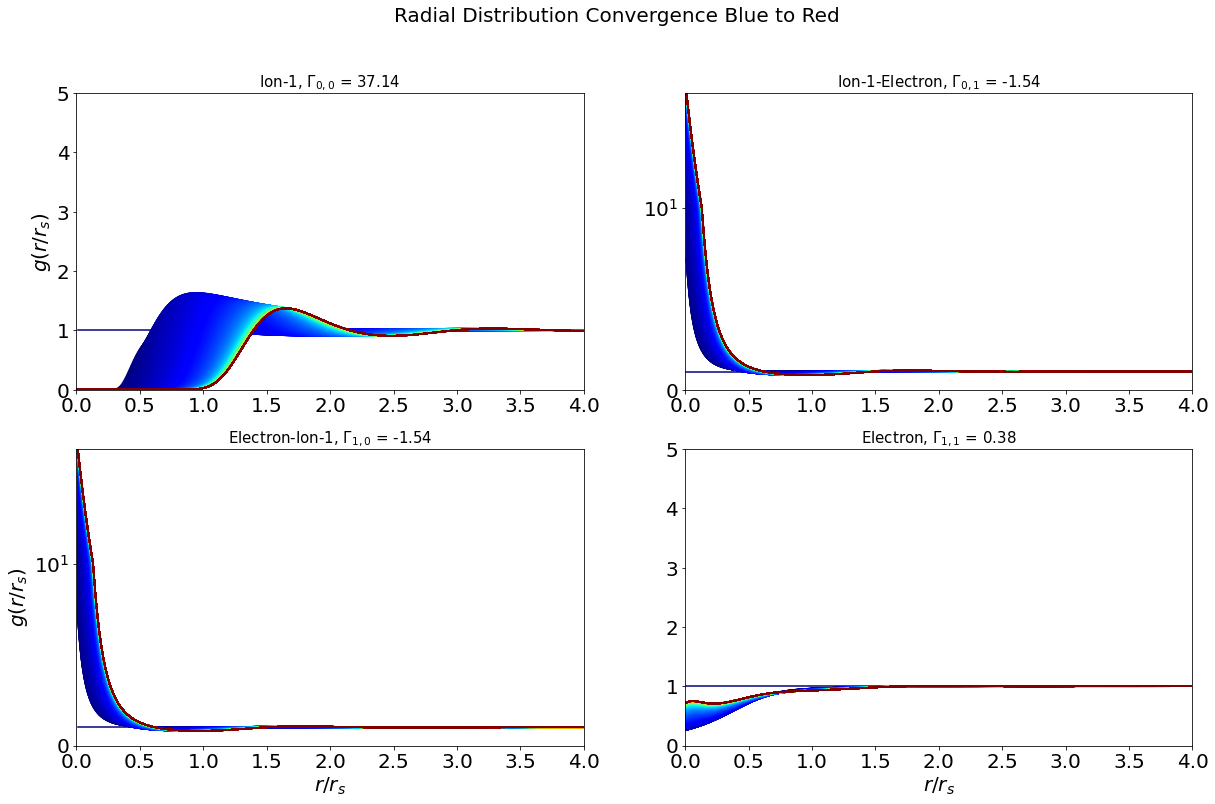

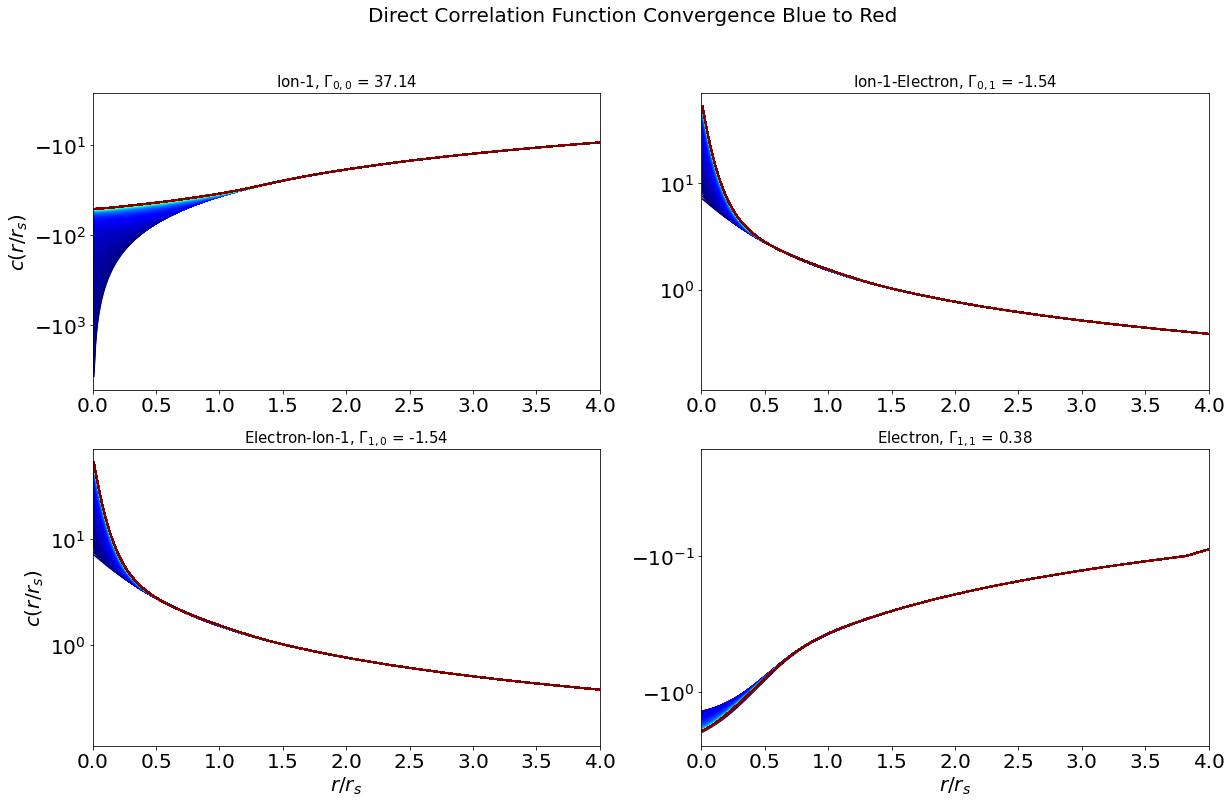

In [70]:
carbon.plot_species_convergence_g(n_slices= int(len(carbon.h_list)/1)  )
carbon.plot_species_convergence_c(n_slices= int(len(carbon.h_list)/1)  )

In [71]:
carbon_one_species, _ = run_hnc_one_ion(ni, Te, Z, A, Zstar, method='fixed', alpha=1 )

Λee = 0.299
Λei = 0.211
Γii=37.137, Γie=-1.529, Γee=0.382 
r_i=1.360
r_e=0.857
θ  =1.26e-01
0: Err in c_r: 1.23e+02, OZ: 5.54e-15, HNC: 1.21e-15, tot: 0.17
1: Err in c_r: 1.52e+01, OZ: 4.17e-15, HNC: 1.36e-15, tot: 0.18
2: Err in c_r: 5.55e+00, OZ: 7.55e-15, HNC: 1.23e-15, tot: 0.21
3: Err in c_r: 3.08e+00, OZ: 2.29e-15, HNC: 1.49e-15, tot: 0.25
4: Err in c_r: 2.07e+00, OZ: 4.19e-15, HNC: 1.46e-15, tot: 0.26
5: Err in c_r: 1.53e+00, OZ: 3.22e-15, HNC: 1.43e-15, tot: 0.27
6: Err in c_r: 1.19e+00, OZ: 2.66e-15, HNC: 1.28e-15, tot: 0.28
7: Err in c_r: 9.46e-01, OZ: 3.43e-15, HNC: 1.26e-15, tot: 0.29
8: Err in c_r: 7.70e-01, OZ: 3.59e-15, HNC: 1.11e-15, tot: 0.29
9: Err in c_r: 6.37e-01, OZ: 2.91e-15, HNC: 1.08e-15, tot: 0.30
10: Err in c_r: 5.33e-01, OZ: 2.10e-15, HNC: 9.71e-16, tot: 0.31
11: Err in c_r: 4.51e-01, OZ: 3.29e-15, HNC: 9.52e-16, tot: 0.32
12: Err in c_r: 3.84e-01, OZ: 3.90e-15, HNC: 1.00e-15, tot: 0.33
13: Err in c_r: 3.30e-01, OZ: 2.15e-15, HNC: 9.45e-16, tot: 0.34
14: Err 

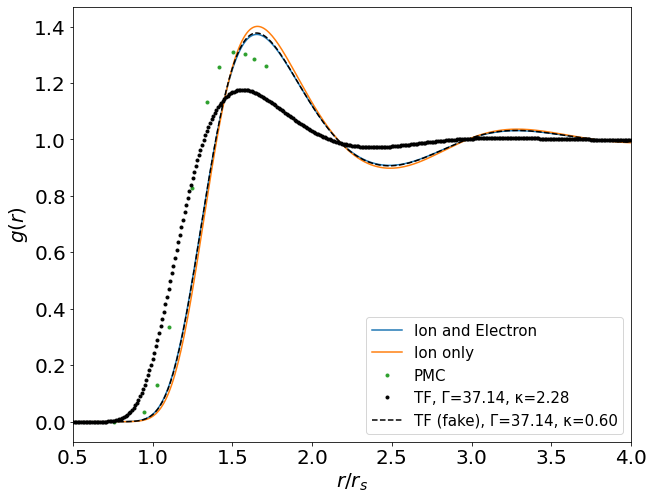

In [76]:
fig, ax = plt.subplots(figsize=(10,8))

data = read_csv("/home/zach/plasma/hnc/data/C_ri_1.36_T8.62eV.txt",header=1, delim_whitespace=True)
# data = read_csv("/home/zach/plasma/hnc/data/C_ri_1.36_T430.9eV.txt",header=1, delim_whitespace=True)
r_data, g_data = data['r/ri'], data['g_ii']

ax.plot(carbon.r_array, carbon.h_r_matrix[0,0]+1, label='Ion and Electron')
ax.plot(carbon.r_array, carbon_one_species.h_r_matrix[0,0]+1, label="Ion only")

ax.plot(r_data, g_data, '.', label='PMC')
ax.plot(carbon_TF.r_array, carbon_TF.h_r_matrix[0,0]+1,'k.',label='TF, Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, κ))
ax.plot(carbon_TF_fake.r_array, carbon_TF_fake.h_r_matrix[0,0]+1,'k--',label='TF (fake), Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, fake_κ))


ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
ax.legend(fontsize=15)


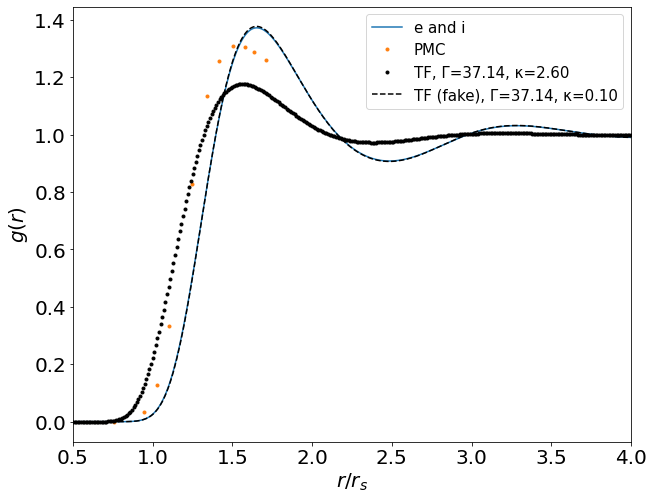

In [133]:
fig, ax = plt.subplots(figsize=(10,8))

data = read_csv("/home/zach/plasma/hnc/data/C_ri_1.36_T8.62eV.txt",header=1, delim_whitespace=True)
# data = read_csv("/home/zach/plasma/hnc/data/C_ri_1.36_T430.9eV.txt",header=1, delim_whitespace=True)
r_data, g_data = data['r/ri'], data['g_ii']

ax.plot(carbon.r_array, carbon.h_r_matrix[0,0]+1, label='e and i')

ax.plot(r_data, g_data, '.', label='PMC')
ax.plot(carbon_TF.r_array, carbon_TF.h_r_matrix[0,0]+1,'k.',label='TF, Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, κ))
ax.plot(carbon_TF_fake.r_array, carbon_TF_fake.h_r_matrix[0,0]+1,'k--',label='TF (fake), Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, fake_κ))


ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
# ax.set_ylim(0.5,5)
# ax.set_yscale('log')
ax.legend(fontsize=15)


## Hydrogen

In [82]:
ni = 5.98e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 1,1
Zstar= 1
hydrogen, hydrogenqsp = run_hnc(ni, Te, Z, A, Zstar )

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
73.2504115213469
HNC α: 1.0e-02, c_err: 7.3e+01 
73.23916312844997
HNC α: 1.1e-02, c_err: 7.3e+01 
73.22792075574746
HNC α: 1.1e-02, c_err: 7.3e+01 
73.21668439683768
HNC α: 1.1e-02, c_err: 7.3e+01 
73.1942296948514
HNC α: 1.2e-02, c_err: 7.3e+01 
73.17179897152036
HNC α: 1.4e-02, c_err: 7.3e+01 
73.12700925790271
HNC α: 1.6e-02, c_err: 7.3e+01 
73.08231485205037
HNC α: 1.8e-02, c_err: 7.3e+01 
72.99321036306095
HNC α: 2.2e-02, c_err: 7.3e+01 
72.90448233332798
HNC α: 2.6e-02, c_err: 7.3e+01 
72.72814320248403
HNC α: 3.4e-02, c_err: 7.3e+01 
72.55327302129434
HNC α: 4.2e-02, c_err: 7.3e+01 
72.20784532253708
HNC α: 5.8e-02, c_err: 7.2e+01 
71.868017665465
HNC α: 7.4e-02, c_err: 7.2e+01 
71.20448737937815
HNC α: 1.1e-01, c_err: 7.1e+01 
70.56142522205496
HNC α: 1.4e-01, c_err: 7.1e+01 
69.33234243761463
HNC α: 2.0e-01, c_err: 6.9e+01 
68.17315971597127
HNC α: 2.7e-01, c_err: 6.8e+01 
66.0413086807

In [84]:
κ = get_κ(Zstar, ri, Ti, hydrogenqsp.E_F)


print("κ= ", κ)
hydrogen_TF, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=κ, which_Tij='geometric', method='fixed',
                            alpha=1e0, num_iterations=1e3)

κ=  1.8589205598017642
Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.946, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 3.49e+01, OZ: 1.38e-16, HNC: 4.58e-17, tot: 0.19
1: Err in c_r: 2.60e+00, OZ: 9.84e-17, HNC: 4.20e-17, tot: 0.21
2: Err in c_r: 7.41e-01, OZ: 1.10e-16, HNC: 3.76e-17, tot: 0.24
3: Err in c_r: 3.34e-01, OZ: 7.76e-17, HNC: 3.23e-17, tot: 0.26
4: Err in c_r: 1.77e-01, OZ: 7.06e-17, HNC: 3.23e-17, tot: 0.28
5: Err in c_r: 9.95e-02, OZ: 8.16e-17, HNC: 3.39e-17, tot: 0.30
6: Err in c_r: 5.73e-02, OZ: 3.65e-17, HNC: 2.88e-17, tot: 0.31
7: Err in c_r: 3.34e-02, OZ: 7.45e-17, HNC: 2.46e-17, tot: 0.32
8: Err in c_r: 1.96e-02, OZ: 6.30e-17, HNC: 2.93e-17, tot: 0.33
9: Err in c_r: 1.16e-02, OZ: 7.13e-17, HNC: 2.77e-17, tot: 0.33
10: Err in c_r: 6.87e-03, OZ: 7.91e-17, HNC: 2.64e-17, tot: 0.33
11: Err in c_r: 4.07e-03, OZ: 4.72e-17, HNC: 3.06e-17, tot: 0.33
12: Err in c_r: 2.42e-03, OZ: 6.71e-17, HNC: 2.35e-17, tot: 0.33
13: Err in c_r: 1.44e-03, OZ: 5.34e-17, HNC: 2.26e-

In [85]:
fake_κ=0.6
hydrogen_TF_fake, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=fake_κ, which_Tij='geometric', 
                               method='fixed', alpha=1e0, num_iterations=1e3)

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.946, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 3.51e+01, OZ: 3.03e-16, HNC: 1.43e-16, tot: 0.19
1: Err in c_r: 2.79e+00, OZ: 6.73e-16, HNC: 1.30e-16, tot: 0.22
2: Err in c_r: 8.98e-01, OZ: 2.23e-16, HNC: 1.17e-16, tot: 0.24
3: Err in c_r: 4.59e-01, OZ: 4.44e-16, HNC: 1.11e-16, tot: 0.27
4: Err in c_r: 2.79e-01, OZ: 3.54e-16, HNC: 1.01e-16, tot: 0.29
5: Err in c_r: 1.81e-01, OZ: 2.74e-16, HNC: 9.50e-17, tot: 0.31
6: Err in c_r: 1.22e-01, OZ: 2.95e-16, HNC: 9.44e-17, tot: 0.33
7: Err in c_r: 8.38e-02, OZ: 1.24e-16, HNC: 8.32e-17, tot: 0.35
8: Err in c_r: 5.83e-02, OZ: 1.36e-16, HNC: 7.84e-17, tot: 0.36
9: Err in c_r: 4.10e-02, OZ: 1.84e-16, HNC: 9.02e-17, tot: 0.36
10: Err in c_r: 2.90e-02, OZ: 2.00e-16, HNC: 8.93e-17, tot: 0.37
11: Err in c_r: 2.05e-02, OZ: 4.15e-16, HNC: 8.00e-17, tot: 0.38
12: Err in c_r: 1.46e-02, OZ: 3.45e-16, HNC: 8.62e-17, tot: 0.38
13: Err in c_r: 1.04e-02, OZ: 1.97e-16, HNC: 7.35e-17, tot: 0.38
14: Err i

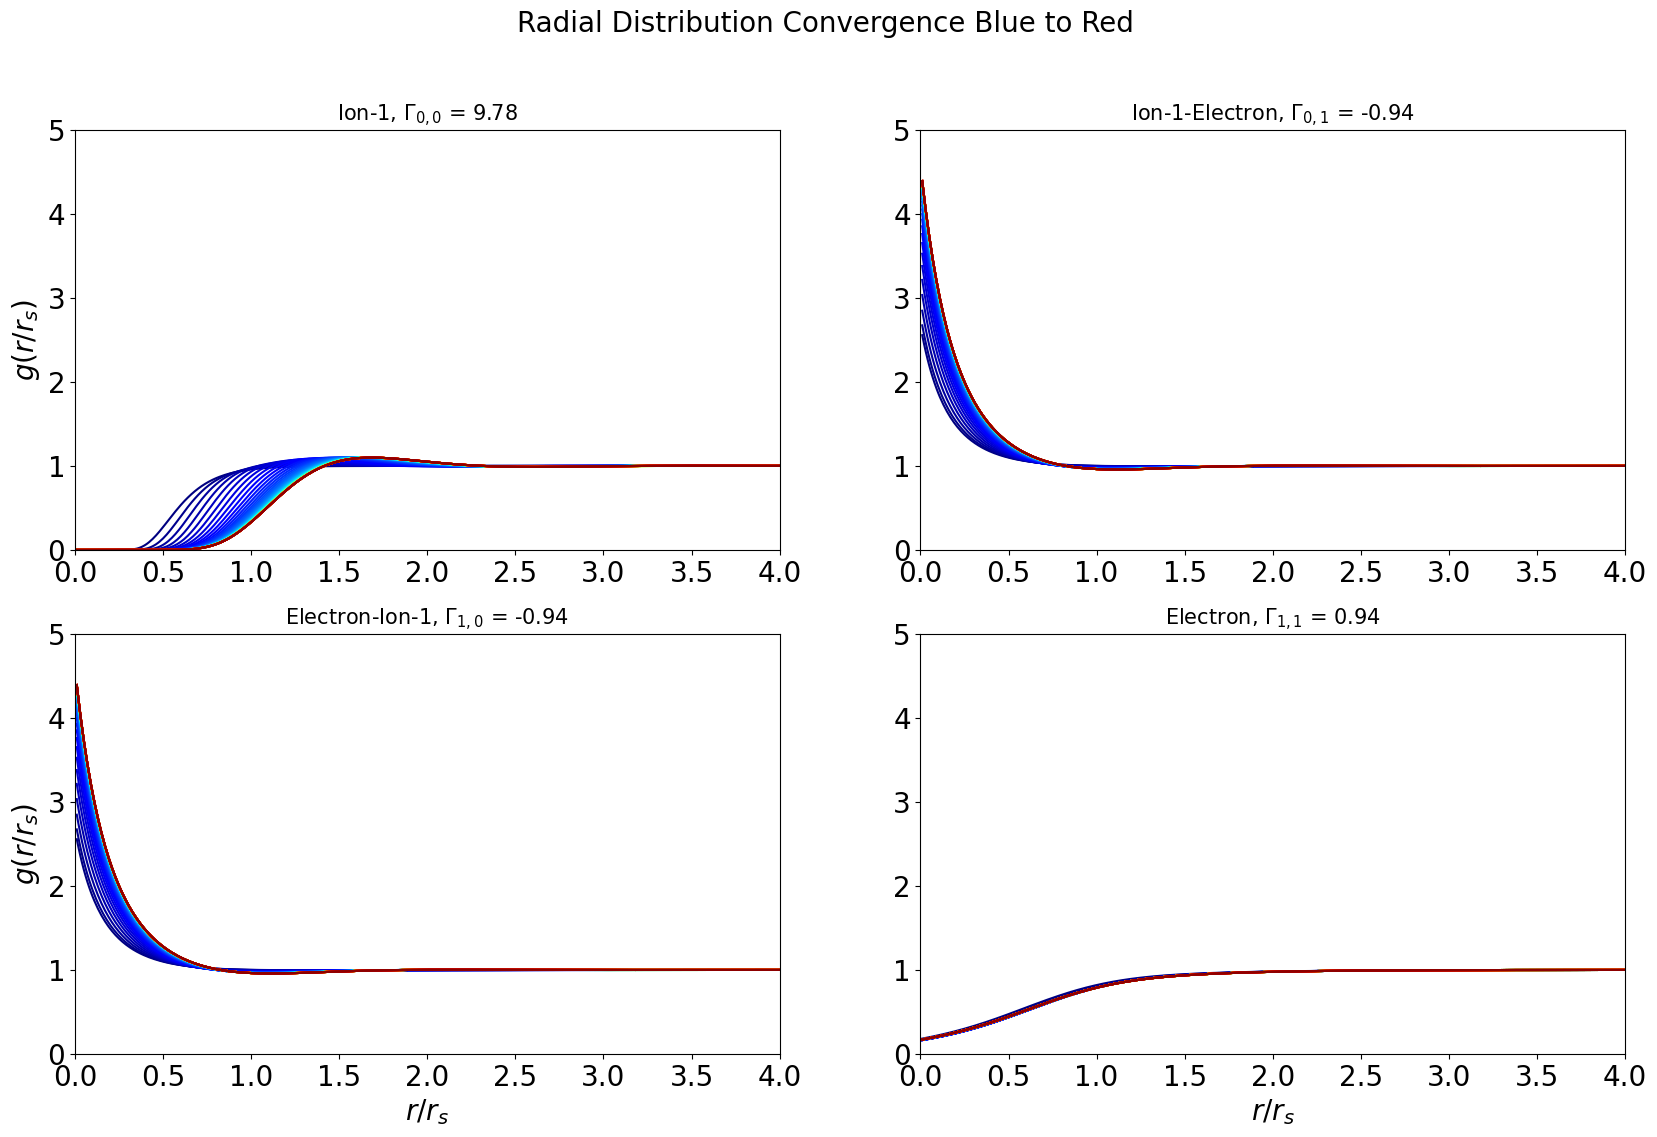

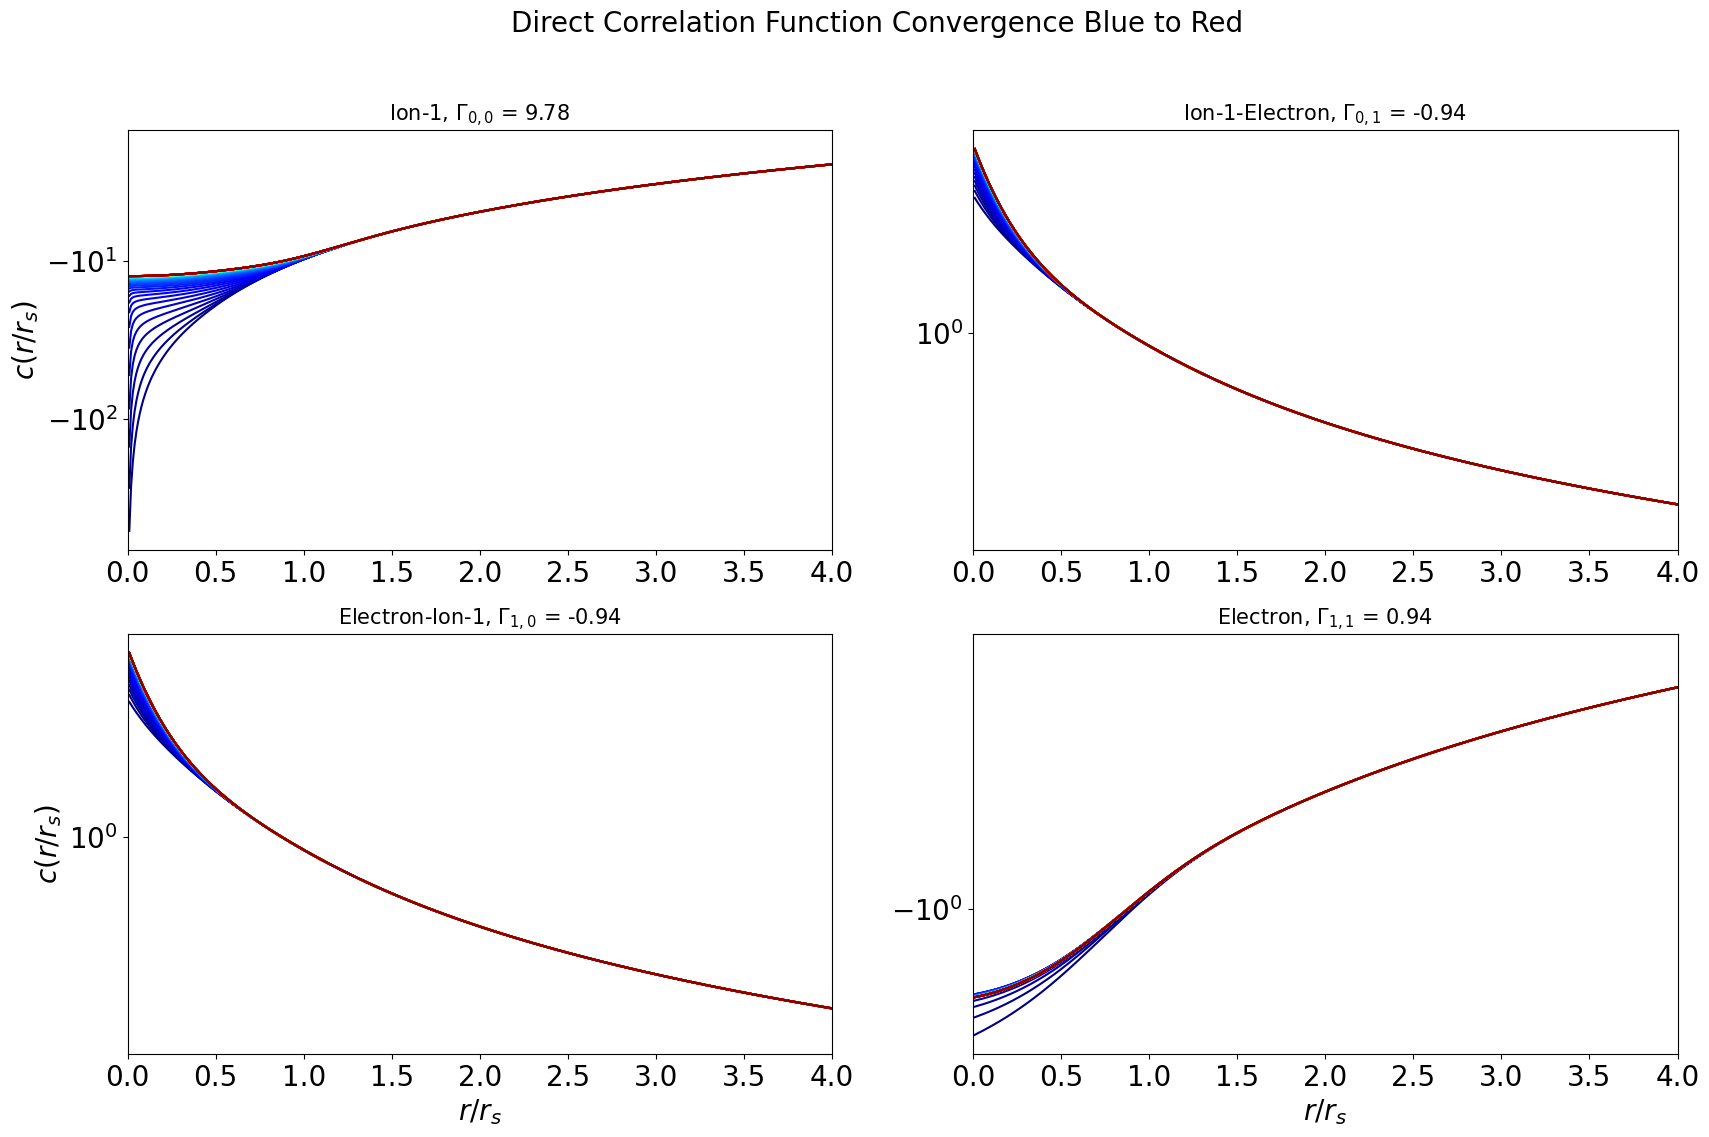

In [13]:
hydrogen.plot_species_convergence_g(n_slices= int(len(hydrogen.h_list)/1)  )
hydrogen.plot_species_convergence_c(n_slices= int(len(hydrogen.h_list)/1)  )

In [14]:
hydrogen_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar )

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00622755] True Optimization terminated successfully.
0: Err in c_r: 2.50e+01, OZ: 1.76e-01, HNC: 1.69e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00150468] True Optimization terminated successfully.
1: Err in c_r: 1.32e+01, OZ: 1.61e-01, HNC: 1.22e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 7.04e+00, OZ: 1.49e-01, HNC: 1.04e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00211778] True Optimization terminated successfully.
3: Err in c_r: 3.81e+00, OZ: 1.28e-01, HNC: 9.42e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00179076] True Optimization terminated successfully.
4: Err in c_r: 2.09e+00, OZ: 1.14e-01, HNC: 9.05e-03
 HNC min: [0.5] True Optimi

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 2.30e-04, OZ: 1.44e-04, HNC: 1.37e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.99e-04, OZ: 1.24e-04, HNC: 1.18e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.72e-04, OZ: 1.08e-04, HNC: 1.02e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
56: Err in c_r: 1.49e-04, OZ: 9.33e-05, HNC: 8.87e-06
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
57: Err in c_r: 1.29e-04, OZ: 8.08e-05, HNC: 7.68e-06
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
58: Err in c_r: 1.12e-04, OZ

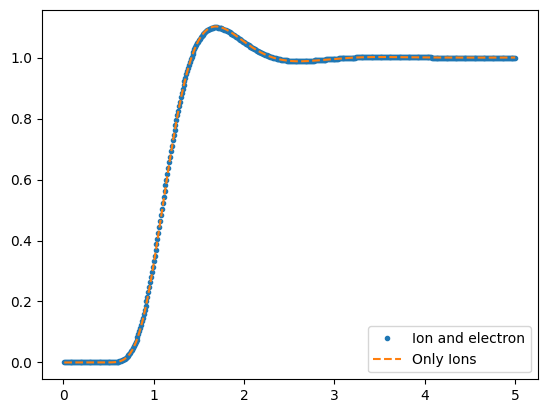

In [15]:
fig, ax = plt.subplots()

ax.plot(hydrogen.r_array, hydrogen.h_r_matrix[0,0]+1,'.', label='Ion and electron')
ax.plot(hydrogen.r_array, hydrogen_one_species.h_r_matrix[0,0]+1, '--',label="Only Ions")
ax.legend()

## Aluminum

In [48]:
ni = 6.03e22 # per cc
Te = 30*eV 
Ti   = 30*eV 
Z, A = 13,27
Zstar= 3
# aluminum_i_one_species, _ = run_hnc_one_ion(ni, Te, Z, A, Zstar, num_iterations=1e3 )
# aluminum_e_one_species, _ = run_hnc_one_electron(ni, Te, 1, 1, Zstar, num_iterations=1e3 )


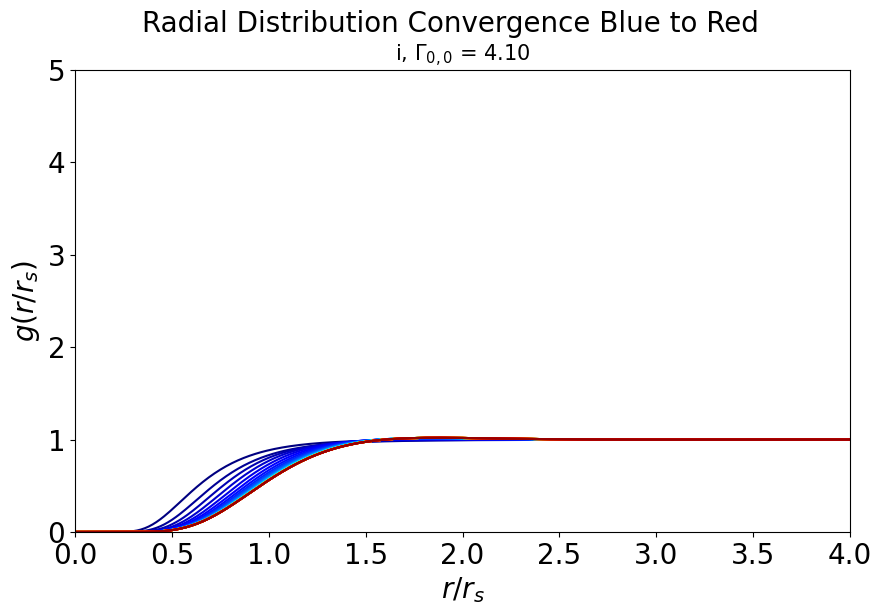

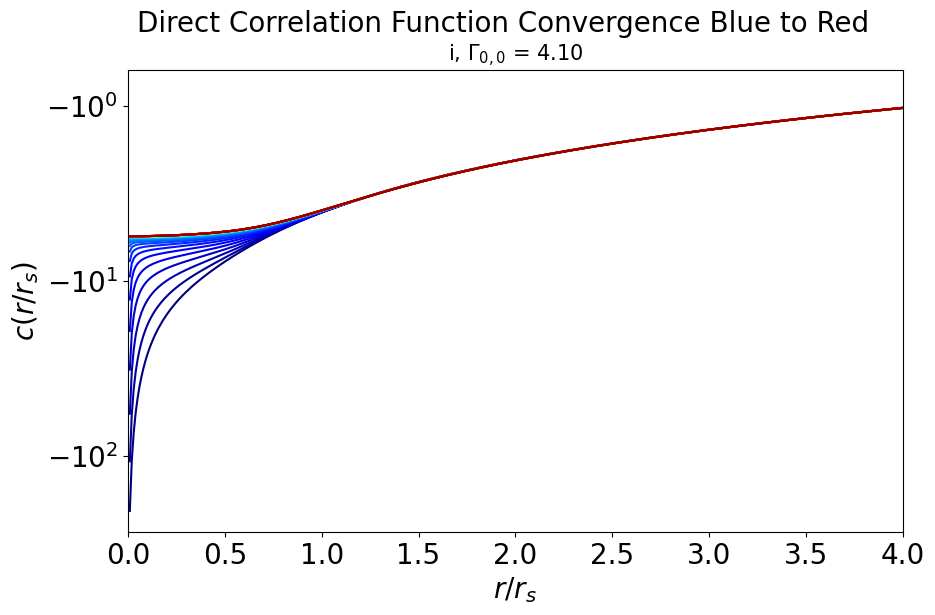

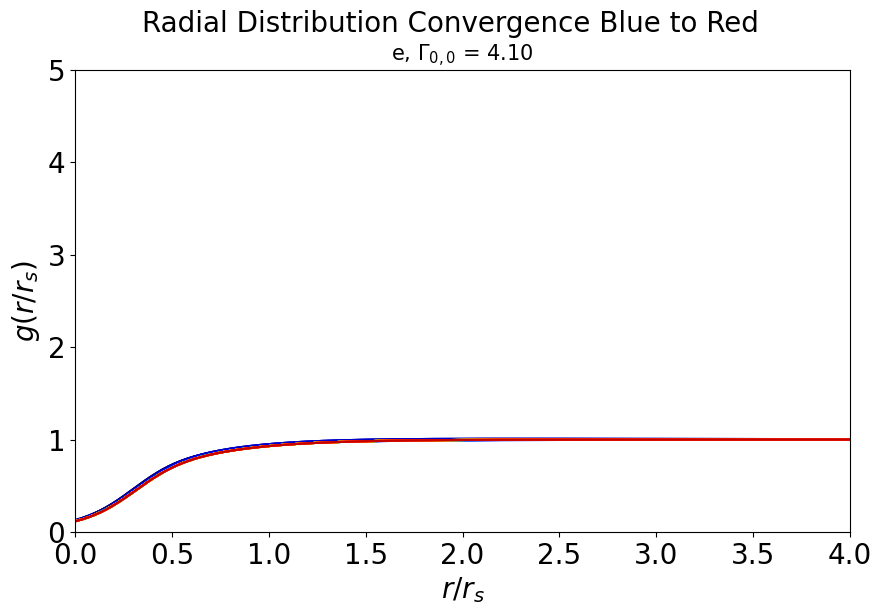

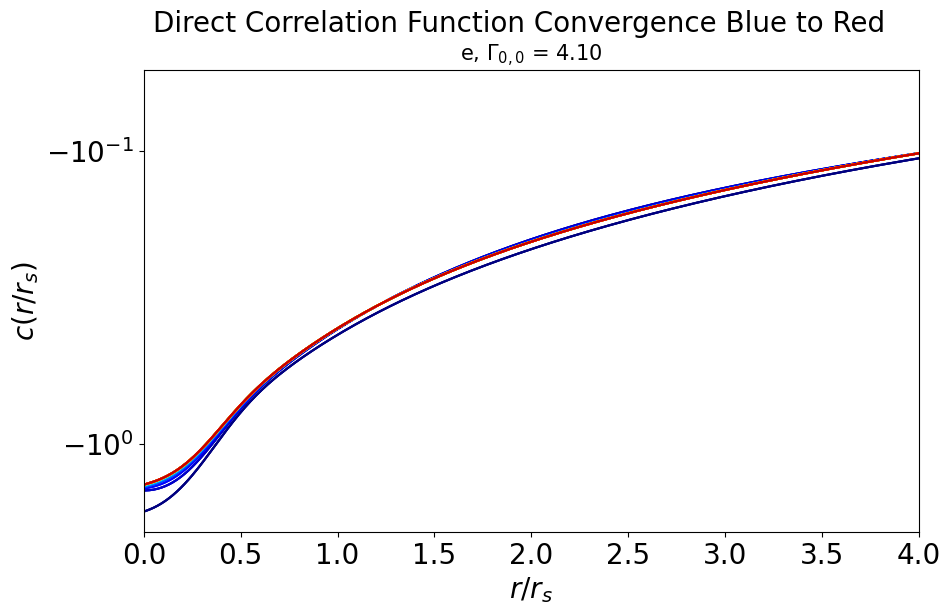

In [19]:
aluminum_i_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_i_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )

aluminum_e_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_e_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )

In [20]:
c_s_r_guess = np.zeros((2,2,N_bins))
c_s_r_guess[0,0] = aluminum_i_one_species.c_s_r_matrix
c_s_r_guess[1,1] = aluminum_e_one_species.c_s_r_matrix

In [21]:
# c_s_r_guess = np.zeros((2,2,N_bins))
# c_s_r_guess[:,:] = aluminum.c_s_r_matrix[:,:]

In [51]:
aluminum, _ = run_hnc(ni, Te, Z, A, Zstar, method='fixed', num_iterations=1e4, alpha=1e-1, c_s_r_guess=c_s_r_guess )

Λee = 0.175
Λei = 0.124
Γii=2.731, Γie=-0.865, Γee=0.288 
r_i=2.989
r_e=2.073
θ  =2.57e+00
0: Err in c_r: 8.14e-01, OZ: 2.62e-01, HNC: 7.24e+79
1: Err in c_r: 9.21e-01, OZ: 2.44e-01, HNC: 5.19e+74
2: Err in c_r: 8.07e-01, OZ: 2.17e-01, HNC: 2.94e+65
3: Err in c_r: 7.14e-01, OZ: 1.92e-01, HNC: 7.32e+57
4: Err in c_r: 6.35e-01, OZ: 1.71e-01, HNC: 2.83e+51
5: Err in c_r: 5.66e-01, OZ: 1.52e-01, HNC: 7.62e+45
6: Err in c_r: 5.05e-01, OZ: 1.35e-01, HNC: 7.92e+40
7: Err in c_r: 4.48e-01, OZ: 1.20e-01, HNC: 2.12e+36
8: Err in c_r: 3.94e-01, OZ: 1.07e-01, HNC: 1.12e+32
9: Err in c_r: 3.44e-01, OZ: 9.54e-02, HNC: 9.94e+27
10: Err in c_r: 2.96e-01, OZ: 8.49e-02, HNC: 1.40e+24
11: Err in c_r: 2.50e-01, OZ: 7.56e-02, HNC: 3.05e+20
12: Err in c_r: 2.07e-01, OZ: 6.72e-02, HNC: 1.06e+17
13: Err in c_r: 1.66e-01, OZ: 5.98e-02, HNC: 6.06e+13
14: Err in c_r: 1.29e-01, OZ: 5.33e-02, HNC: 5.99e+10
15: Err in c_r: 9.47e-02, OZ: 4.75e-02, HNC: 1.05e+08
16: Err in c_r: 6.46e-02, OZ: 4.25e-02, HNC: 3.38e+05
1

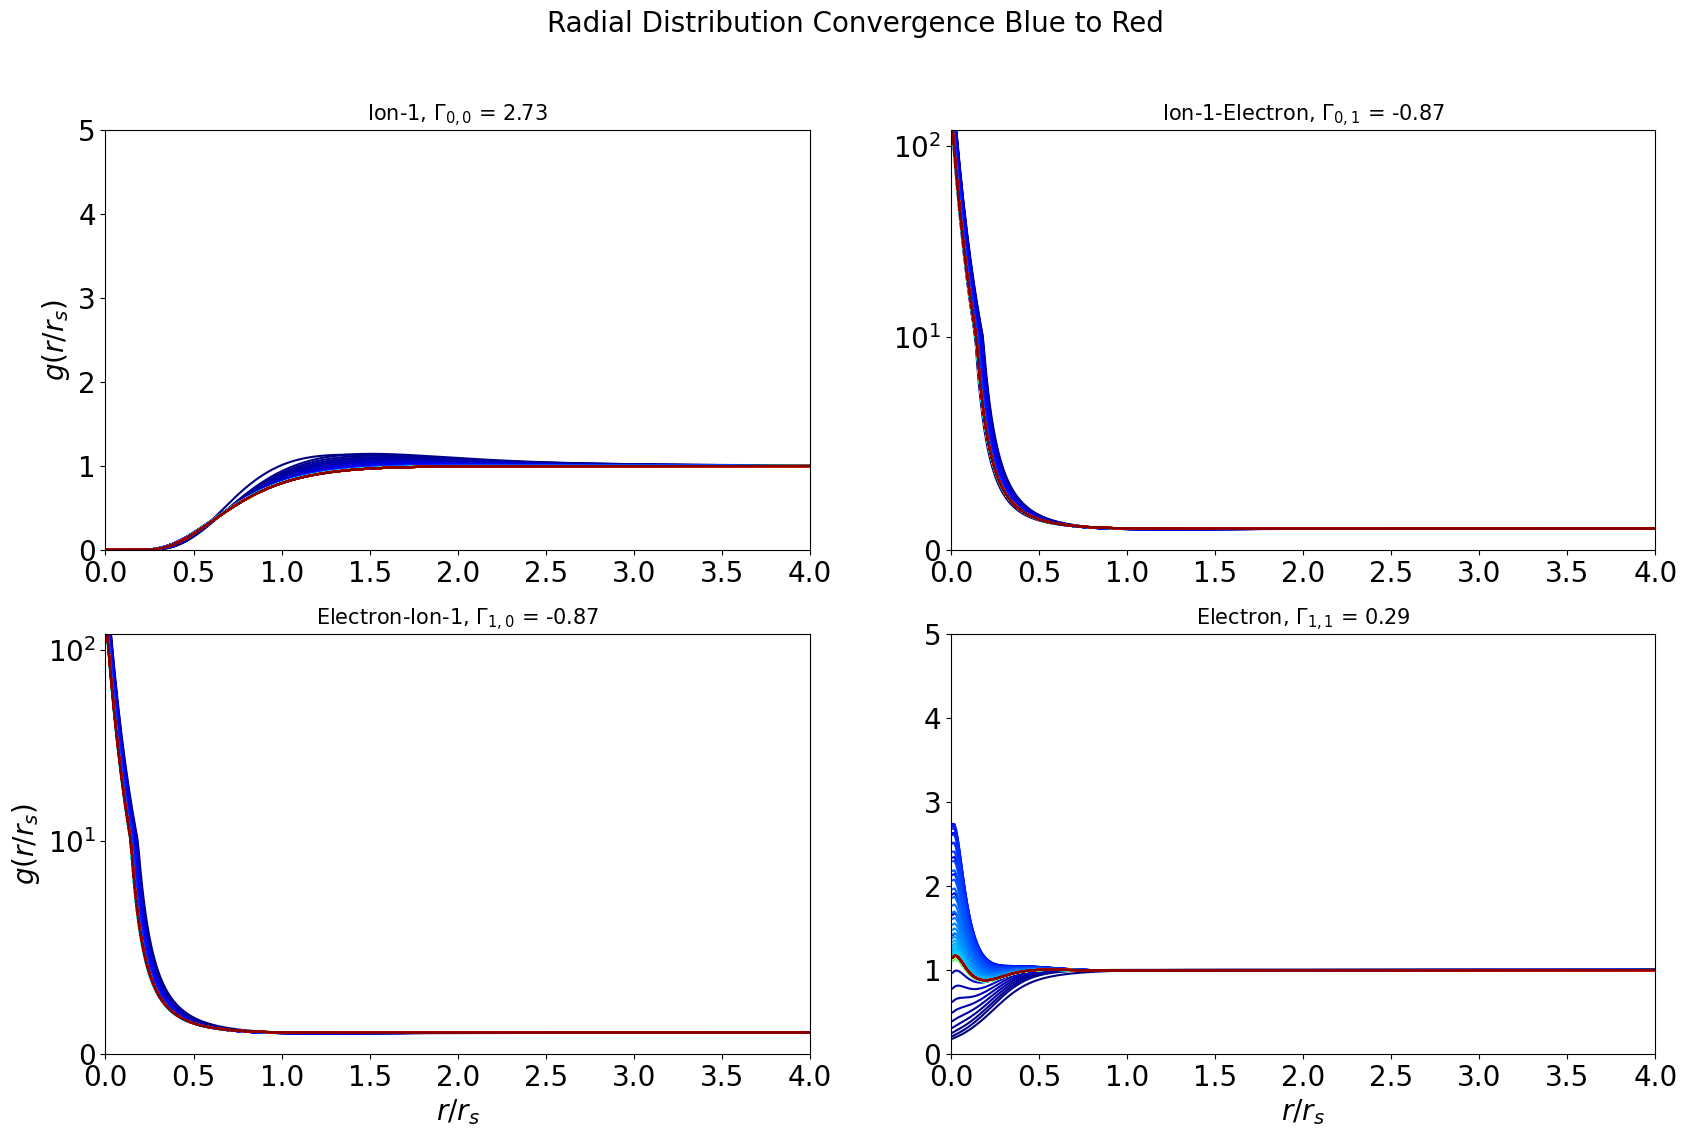

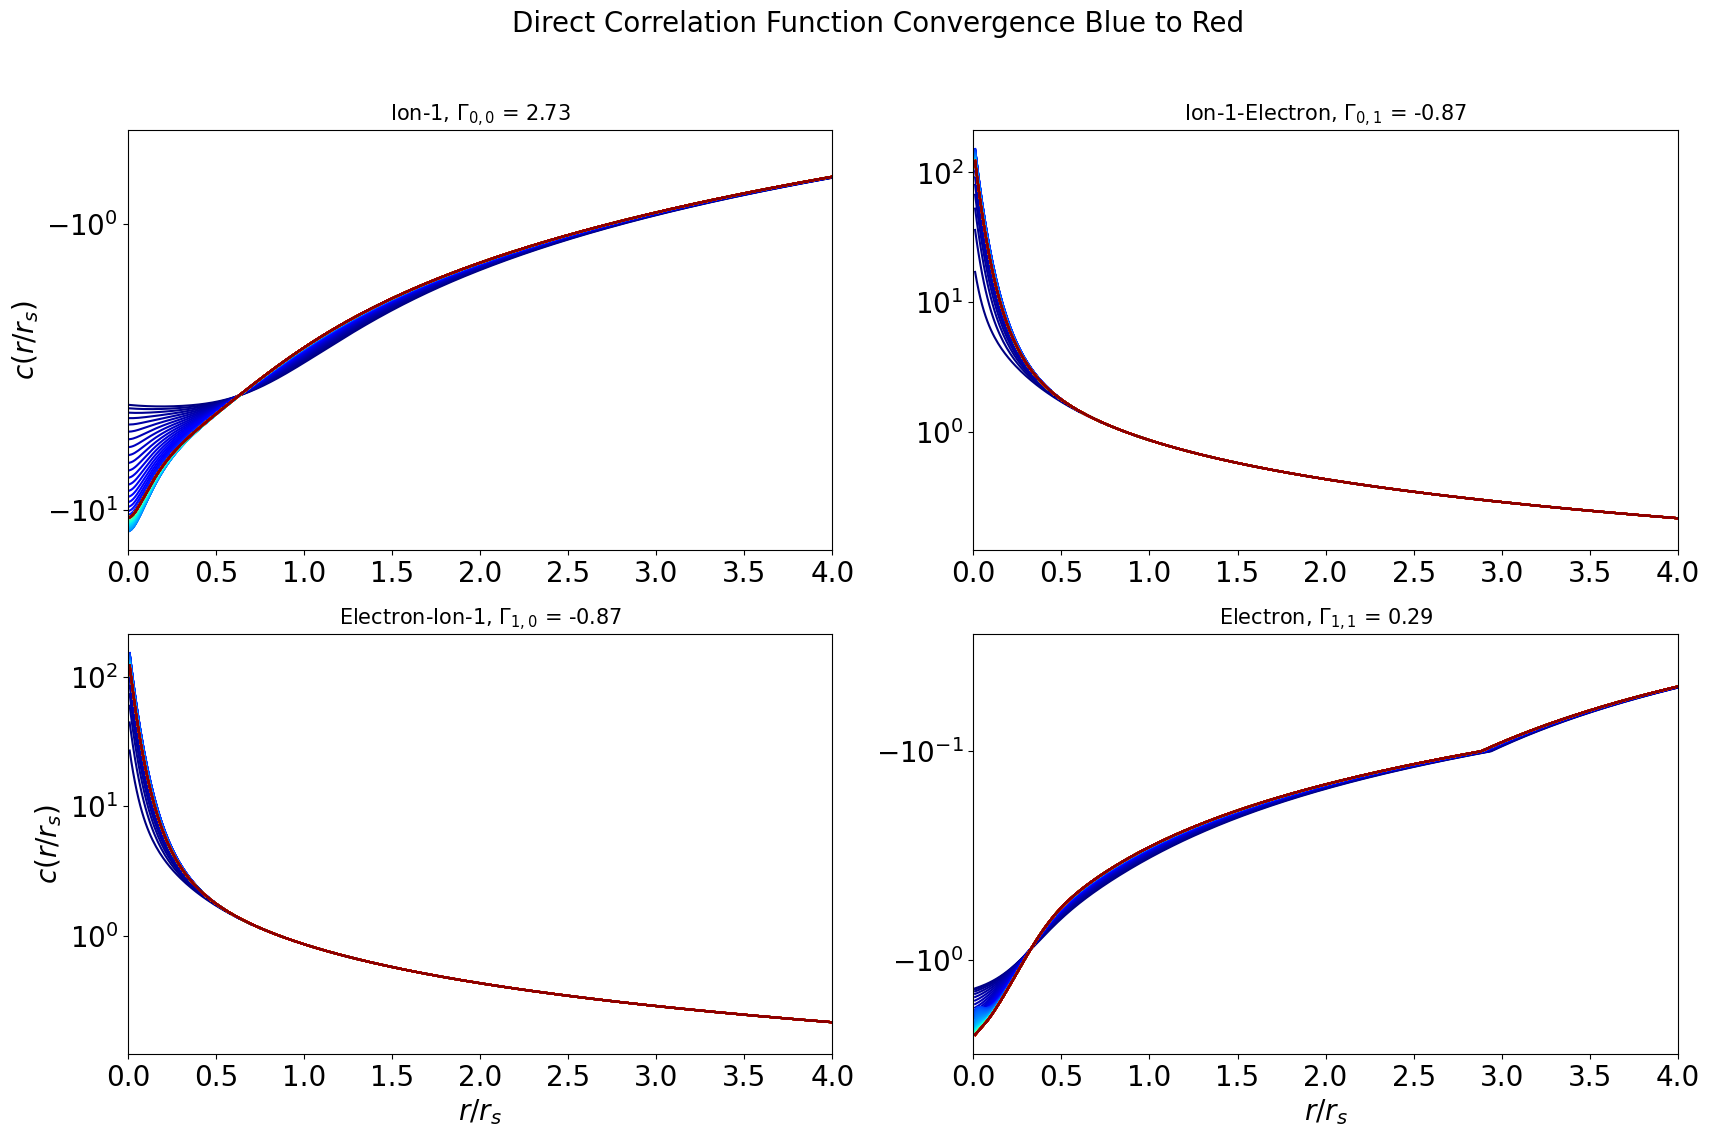

In [52]:
aluminum.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminum.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )

## Copper

In [60]:
ni = 8.49e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 29,63.55
Zstar= 1.206
c_s_r_guess = np.zeros((2,2,N_bins))
c_s_r_guess[0,0] = carbon_one_species.c_s_r_matrix


copper,_ = run_hnc(ni, Te, Z, A, Zstar ,num_iterations=1e3, method='fixed',alpha=1e-2, c_s_r_guess=c_s_r_guess)

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
0: Err in c_r: 1.37e-01, OZ: 3.07e+01, HNC: 1.38e+46
1: Err in c_r: 6.81e-02, OZ: 1.93e+01, HNC: 2.78e+19
2: Err in c_r: 5.50e-02, OZ: 1.60e+01, HNC: 4.00e+15
3: Err in c_r: 4.58e-02, OZ: 1.37e+01, HNC: 6.24e+12
4: Err in c_r: 3.92e-02, OZ: 1.20e+01, HNC: 5.50e+10
5: Err in c_r: 3.43e-02, OZ: 1.07e+01, HNC: 1.57e+09
6: Err in c_r: 3.05e-02, OZ: 9.68e+00, HNC: 1.00e+08
7: Err in c_r: 2.76e-02, OZ: 8.87e+00, HNC: 1.19e+07
8: Err in c_r: 2.53e-02, OZ: 8.21e+00, HNC: 3.41e+06
9: Err in c_r: 2.34e-02, OZ: 7.65e+00, HNC: 2.26e+06
10: Err in c_r: 2.19e-02, OZ: 7.18e+00, HNC: 1.78e+06
11: Err in c_r: 2.05e-02, OZ: 6.77e+00, HNC: 1.45e+06
12: Err in c_r: 1.94e-02, OZ: 6.41e+00, HNC: 1.20e+06
13: Err in c_r: 1.85e-02, OZ: 6.09e+00, HNC: 1.01e+06
14: Err in c_r: 1.76e-02, OZ: 5.81e+00, HNC: 8.47e+05
15: Err in c_r: 1.69e-02, OZ: 5.55e+00, HNC: 7.16e+05
16: Err in c_r: 1.63e-02, OZ: 5.32e+00, HNC: 6.08e+05


171: Err in c_r: 2.32e-03, OZ: 4.95e-01, HNC: 1.64e+00
172: Err in c_r: 2.32e-03, OZ: 4.90e-01, HNC: 1.61e+00
173: Err in c_r: 2.32e-03, OZ: 4.85e-01, HNC: 1.58e+00
174: Err in c_r: 2.31e-03, OZ: 4.80e-01, HNC: 1.55e+00
175: Err in c_r: 2.31e-03, OZ: 4.76e-01, HNC: 1.52e+00
176: Err in c_r: 2.31e-03, OZ: 4.71e-01, HNC: 1.49e+00
177: Err in c_r: 2.31e-03, OZ: 4.67e-01, HNC: 1.47e+00
178: Err in c_r: 2.31e-03, OZ: 4.62e-01, HNC: 1.44e+00
179: Err in c_r: 2.31e-03, OZ: 4.58e-01, HNC: 1.42e+00
180: Err in c_r: 2.30e-03, OZ: 4.53e-01, HNC: 1.39e+00
181: Err in c_r: 2.30e-03, OZ: 4.49e-01, HNC: 1.37e+00
182: Err in c_r: 2.30e-03, OZ: 4.45e-01, HNC: 1.35e+00
183: Err in c_r: 2.30e-03, OZ: 4.40e-01, HNC: 1.33e+00
184: Err in c_r: 2.30e-03, OZ: 4.36e-01, HNC: 1.31e+00
185: Err in c_r: 2.30e-03, OZ: 4.32e-01, HNC: 1.29e+00
186: Err in c_r: 2.30e-03, OZ: 4.28e-01, HNC: 1.27e+00
187: Err in c_r: 2.30e-03, OZ: 4.24e-01, HNC: 1.25e+00
188: Err in c_r: 2.29e-03, OZ: 4.20e-01, HNC: 1.23e+00
189: Err i

320: Err in c_r: 2.03e-03, OZ: 1.52e-01, HNC: 8.27e-01
321: Err in c_r: 2.03e-03, OZ: 1.51e-01, HNC: 8.28e-01
322: Err in c_r: 2.03e-03, OZ: 1.50e-01, HNC: 8.30e-01
323: Err in c_r: 2.02e-03, OZ: 1.49e-01, HNC: 8.31e-01
324: Err in c_r: 2.02e-03, OZ: 1.48e-01, HNC: 8.33e-01
325: Err in c_r: 2.02e-03, OZ: 1.47e-01, HNC: 8.35e-01
326: Err in c_r: 2.01e-03, OZ: 1.47e-01, HNC: 8.36e-01
327: Err in c_r: 2.01e-03, OZ: 1.46e-01, HNC: 8.38e-01
328: Err in c_r: 2.01e-03, OZ: 1.45e-01, HNC: 8.39e-01
329: Err in c_r: 2.00e-03, OZ: 1.44e-01, HNC: 8.41e-01
330: Err in c_r: 2.00e-03, OZ: 1.43e-01, HNC: 8.43e-01
331: Err in c_r: 2.00e-03, OZ: 1.42e-01, HNC: 8.44e-01
332: Err in c_r: 1.99e-03, OZ: 1.41e-01, HNC: 8.46e-01
333: Err in c_r: 1.99e-03, OZ: 1.41e-01, HNC: 8.47e-01
334: Err in c_r: 1.99e-03, OZ: 1.40e-01, HNC: 8.49e-01
335: Err in c_r: 1.98e-03, OZ: 1.39e-01, HNC: 8.51e-01
336: Err in c_r: 1.98e-03, OZ: 1.38e-01, HNC: 8.52e-01
337: Err in c_r: 1.98e-03, OZ: 1.37e-01, HNC: 8.54e-01
338: Err i

476: Err in c_r: 1.50e-03, OZ: 7.55e-02, HNC: 9.68e-01
477: Err in c_r: 1.50e-03, OZ: 7.53e-02, HNC: 9.68e-01
478: Err in c_r: 1.49e-03, OZ: 7.50e-02, HNC: 9.67e-01
479: Err in c_r: 1.49e-03, OZ: 7.48e-02, HNC: 9.67e-01
480: Err in c_r: 1.49e-03, OZ: 7.45e-02, HNC: 9.67e-01
481: Err in c_r: 1.48e-03, OZ: 7.43e-02, HNC: 9.67e-01
482: Err in c_r: 1.48e-03, OZ: 7.41e-02, HNC: 9.66e-01
483: Err in c_r: 1.48e-03, OZ: 7.38e-02, HNC: 9.66e-01
484: Err in c_r: 1.47e-03, OZ: 7.36e-02, HNC: 9.66e-01
485: Err in c_r: 1.47e-03, OZ: 7.34e-02, HNC: 9.65e-01
486: Err in c_r: 1.47e-03, OZ: 7.31e-02, HNC: 9.65e-01
487: Err in c_r: 1.46e-03, OZ: 7.29e-02, HNC: 9.64e-01
488: Err in c_r: 1.46e-03, OZ: 7.27e-02, HNC: 9.64e-01
489: Err in c_r: 1.46e-03, OZ: 7.24e-02, HNC: 9.64e-01
490: Err in c_r: 1.45e-03, OZ: 7.22e-02, HNC: 9.63e-01
491: Err in c_r: 1.45e-03, OZ: 7.20e-02, HNC: 9.63e-01
492: Err in c_r: 1.45e-03, OZ: 7.18e-02, HNC: 9.62e-01
493: Err in c_r: 1.44e-03, OZ: 7.16e-02, HNC: 9.62e-01
494: Err i

648: Err in c_r: 1.00e-03, OZ: 4.77e-02, HNC: 7.79e-01
649: Err in c_r: 1.00e-03, OZ: 4.76e-02, HNC: 7.77e-01
650: Err in c_r: 9.99e-04, OZ: 4.75e-02, HNC: 7.76e-01
651: Err in c_r: 9.96e-04, OZ: 4.74e-02, HNC: 7.74e-01
652: Err in c_r: 9.94e-04, OZ: 4.73e-02, HNC: 7.73e-01
653: Err in c_r: 9.92e-04, OZ: 4.72e-02, HNC: 7.71e-01
654: Err in c_r: 9.89e-04, OZ: 4.71e-02, HNC: 7.70e-01
655: Err in c_r: 9.87e-04, OZ: 4.70e-02, HNC: 7.68e-01
656: Err in c_r: 9.85e-04, OZ: 4.69e-02, HNC: 7.66e-01
657: Err in c_r: 9.82e-04, OZ: 4.68e-02, HNC: 7.65e-01
658: Err in c_r: 9.80e-04, OZ: 4.67e-02, HNC: 7.63e-01
659: Err in c_r: 9.77e-04, OZ: 4.66e-02, HNC: 7.62e-01
660: Err in c_r: 9.75e-04, OZ: 4.65e-02, HNC: 7.60e-01
661: Err in c_r: 9.73e-04, OZ: 4.63e-02, HNC: 7.59e-01
662: Err in c_r: 9.70e-04, OZ: 4.62e-02, HNC: 7.57e-01
663: Err in c_r: 9.68e-04, OZ: 4.61e-02, HNC: 7.55e-01
664: Err in c_r: 9.66e-04, OZ: 4.60e-02, HNC: 7.54e-01
665: Err in c_r: 9.63e-04, OZ: 4.59e-02, HNC: 7.52e-01
666: Err i

797: Err in c_r: 6.99e-04, OZ: 3.44e-02, HNC: 5.53e-01
798: Err in c_r: 6.98e-04, OZ: 3.43e-02, HNC: 5.52e-01
799: Err in c_r: 6.96e-04, OZ: 3.43e-02, HNC: 5.50e-01
800: Err in c_r: 6.94e-04, OZ: 3.42e-02, HNC: 5.49e-01
801: Err in c_r: 6.93e-04, OZ: 3.41e-02, HNC: 5.48e-01
802: Err in c_r: 6.91e-04, OZ: 3.40e-02, HNC: 5.46e-01
803: Err in c_r: 6.89e-04, OZ: 3.40e-02, HNC: 5.45e-01
804: Err in c_r: 6.87e-04, OZ: 3.39e-02, HNC: 5.44e-01
805: Err in c_r: 6.86e-04, OZ: 3.38e-02, HNC: 5.42e-01
806: Err in c_r: 6.84e-04, OZ: 3.38e-02, HNC: 5.41e-01
807: Err in c_r: 6.83e-04, OZ: 3.37e-02, HNC: 5.40e-01
808: Err in c_r: 6.81e-04, OZ: 3.36e-02, HNC: 5.38e-01
809: Err in c_r: 6.79e-04, OZ: 3.35e-02, HNC: 5.37e-01
810: Err in c_r: 6.78e-04, OZ: 3.35e-02, HNC: 5.36e-01
811: Err in c_r: 6.76e-04, OZ: 3.34e-02, HNC: 5.34e-01
812: Err in c_r: 6.74e-04, OZ: 3.33e-02, HNC: 5.33e-01
813: Err in c_r: 6.73e-04, OZ: 3.33e-02, HNC: 5.32e-01
814: Err in c_r: 6.71e-04, OZ: 3.32e-02, HNC: 5.30e-01
815: Err i

951: Err in c_r: 4.82e-04, OZ: 2.48e-02, HNC: 3.74e-01
952: Err in c_r: 4.81e-04, OZ: 2.48e-02, HNC: 3.73e-01
953: Err in c_r: 4.80e-04, OZ: 2.47e-02, HNC: 3.72e-01
954: Err in c_r: 4.79e-04, OZ: 2.47e-02, HNC: 3.71e-01
955: Err in c_r: 4.78e-04, OZ: 2.46e-02, HNC: 3.70e-01
956: Err in c_r: 4.76e-04, OZ: 2.46e-02, HNC: 3.69e-01
957: Err in c_r: 4.75e-04, OZ: 2.45e-02, HNC: 3.68e-01
958: Err in c_r: 4.74e-04, OZ: 2.45e-02, HNC: 3.67e-01
959: Err in c_r: 4.73e-04, OZ: 2.44e-02, HNC: 3.66e-01
960: Err in c_r: 4.72e-04, OZ: 2.44e-02, HNC: 3.65e-01
961: Err in c_r: 4.71e-04, OZ: 2.43e-02, HNC: 3.64e-01
962: Err in c_r: 4.70e-04, OZ: 2.43e-02, HNC: 3.63e-01
963: Err in c_r: 4.69e-04, OZ: 2.42e-02, HNC: 3.62e-01
964: Err in c_r: 4.67e-04, OZ: 2.42e-02, HNC: 3.62e-01
965: Err in c_r: 4.66e-04, OZ: 2.41e-02, HNC: 3.61e-01
966: Err in c_r: 4.65e-04, OZ: 2.41e-02, HNC: 3.60e-01
967: Err in c_r: 4.64e-04, OZ: 2.40e-02, HNC: 3.59e-01
968: Err in c_r: 4.63e-04, OZ: 2.40e-02, HNC: 3.58e-01
969: Err i

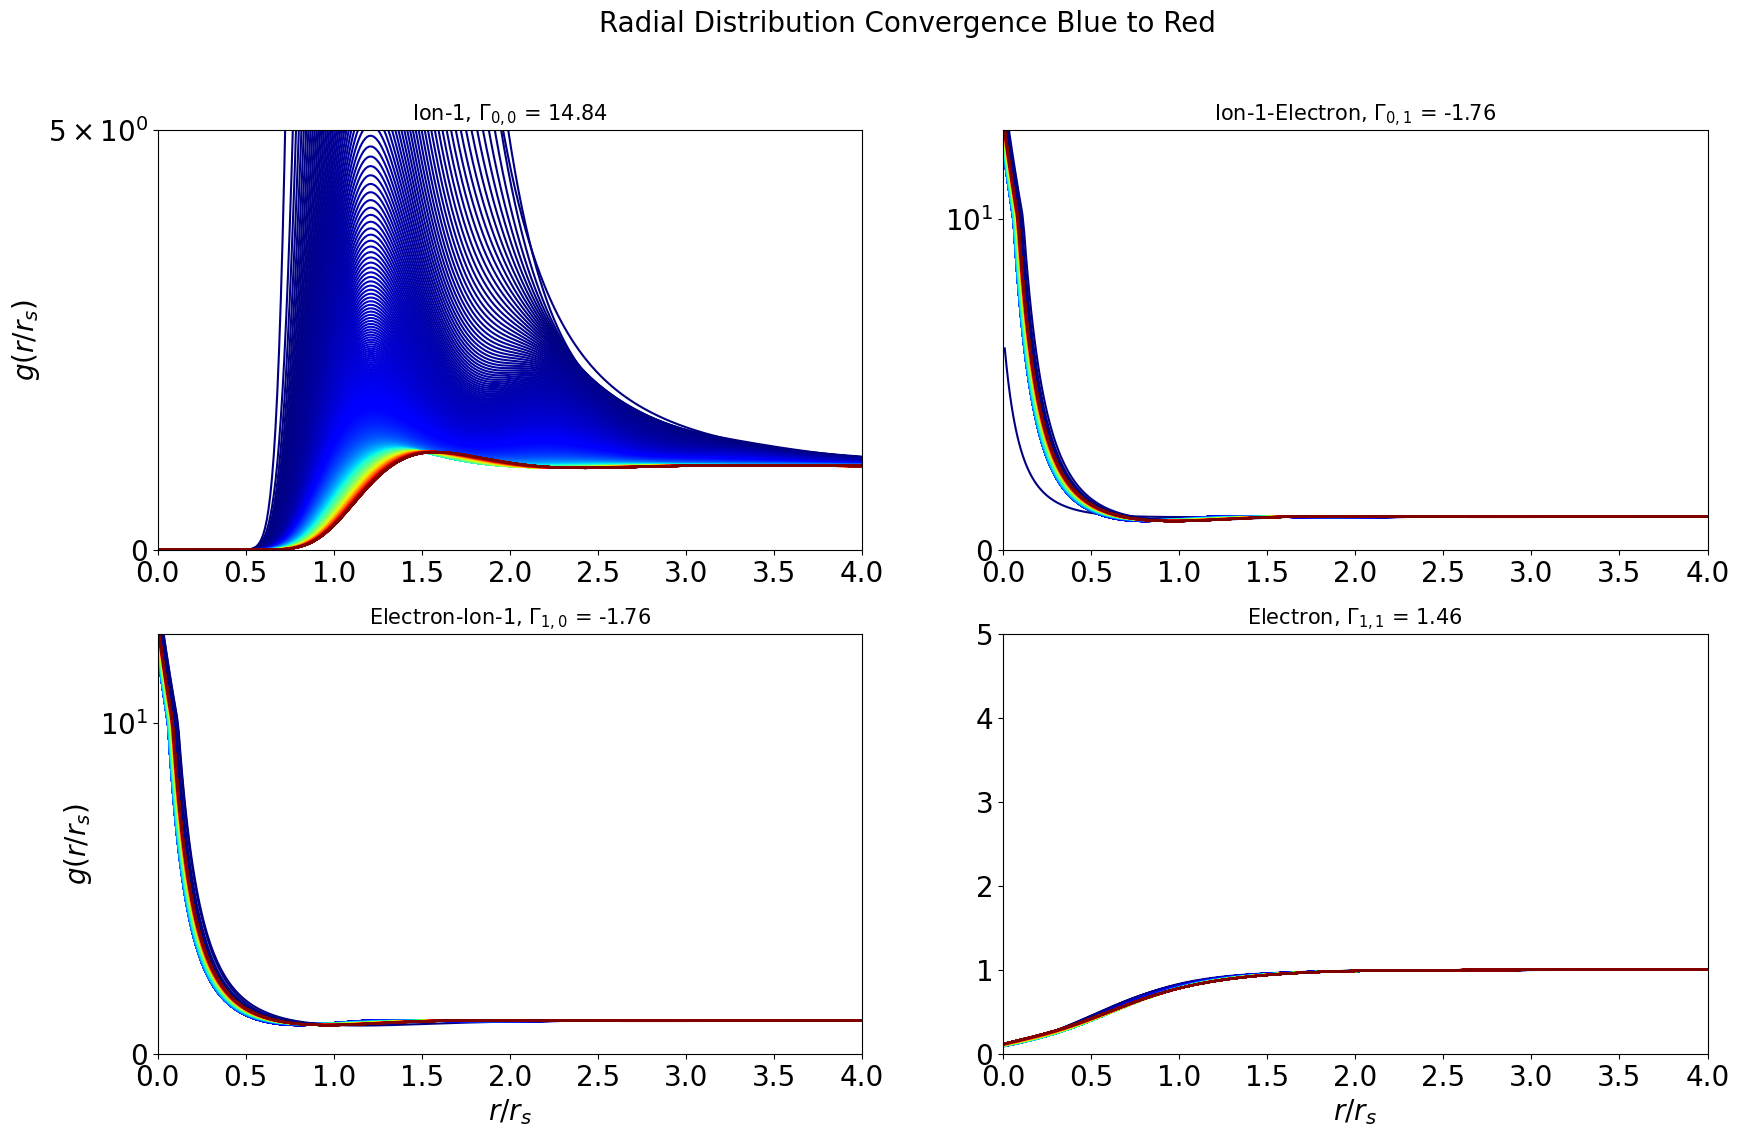

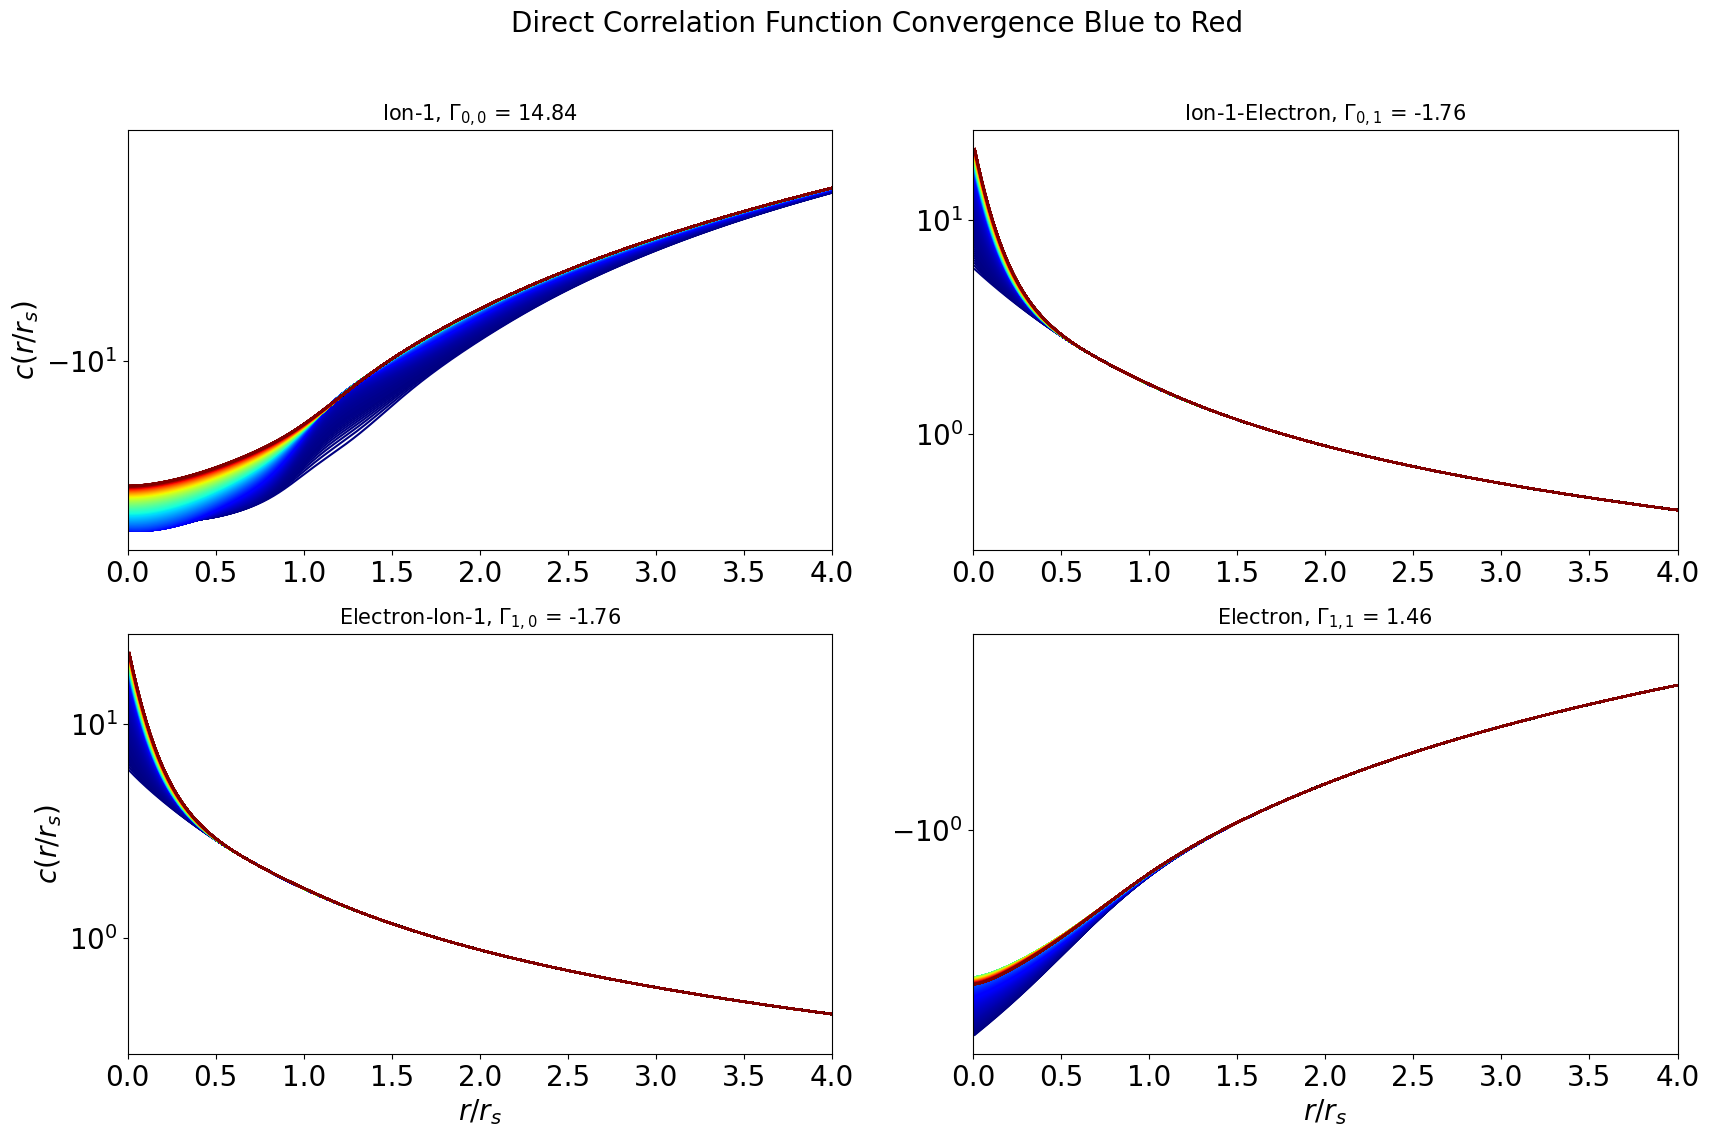

In [61]:
copper.plot_species_convergence_g(n_slices= int(len(copper.h_list)/1)  )
copper.plot_species_convergence_c(n_slices= int(len(copper.h_list)/1)  )

In [62]:
copper_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar )

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00313851] True Optimization terminated successfully.
0: Err in c_r: 3.70e+01, OZ: 2.17e-01, HNC: 1.60e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 1.99e+01, OZ: 2.05e-01, HNC: 1.15e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 1.08e+01, OZ: 1.90e-01, HNC: 9.94e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 5.91e+00, OZ: 1.77e-01, HNC: 9.63e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 3.32e+00, OZ: 1.65e-01, HNC: 9.65e-03
 HNC min: [0.5] True Optimization terminated succe

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
50: Err in c_r: 2.56e-03, OZ: 1.68e-03, HNC: 1.21e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 2.30e-03, OZ: 1.51e-03, HNC: 1.08e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 2.06e-03, OZ: 1.36e-03, HNC: 9.71e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 1.85e-03, OZ: 1.22e-03, HNC: 8.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.66e-03, OZ: 1.09e-03, HNC: 7.82e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.49e-03, OZ

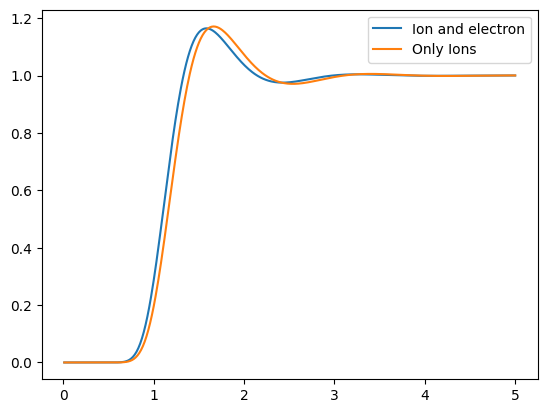

In [63]:
fig, ax = plt.subplots()

ax.plot(copper.r_array, copper.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(copper.r_array, copper_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



# Compare to Dharma Wardana (Not converging yet!)

In [110]:
hydrogen_DW_qsp.Te_c, Te

(6.605732776664351, 0.012495408)

In [111]:
hydrogen_DW_qsp.E_F, hydrogen_DW_qsp.Te_c

(9.204364354277455, 6.605732776664351)

In [104]:
# ri = QSP_HNC.rs_from_n(6.03e30*aB**3)
ri = 0.4473#qsp.rs_from_n(1.8e31*aB**3)
ni = QSP_HNC.n_from_rs(ri)/aB**3*1e-6
Te = 0.34*eV 
Ti   = 0.34*eV 
Z, A = 1, 1
Zstar= 1

hydrogen_DW, hydrogen_DW_qsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3, method='fixed' ,alpha=1e-1)
hydrogen_DW_one_species, _ = run_hnc_one_ion(ni, Te, Z, A, Zstar, num_iterations=1e3,method='fixed' ,alpha=1e-1)

Λee = 0.491
Λei = 0.347
Γii=178.917, Γie=-0.338, Γee=0.338 
r_i=0.447
r_e=0.447
θ  =1.36e-03
0: Err in c_r: 2.51e+01, OZ: 4.47e-01, HNC: 1.74e-02, tot: 0.41
1: Err in c_r: 2.31e+01, OZ: 4.42e-01, HNC: 1.46e-02, tot: 0.41
2: Err in c_r: 2.13e+01, OZ: 4.37e-01, HNC: 1.26e-02, tot: 0.40
3: Err in c_r: 1.97e+01, OZ: 4.32e-01, HNC: 1.11e-02, tot: 0.40
4: Err in c_r: 1.81e+01, OZ: 4.27e-01, HNC: 9.79e-03, tot: 0.39
5: Err in c_r: 1.67e+01, OZ: 4.22e-01, HNC: 8.70e-03, tot: 0.39
6: Err in c_r: 1.54e+01, OZ: 4.18e-01, HNC: 7.79e-03, tot: 0.39
7: Err in c_r: 1.42e+01, OZ: 4.14e-01, HNC: 7.07e-03, tot: 0.38
8: Err in c_r: 1.31e+01, OZ: 4.10e-01, HNC: 6.80e-03, tot: 0.38
9: Err in c_r: 1.21e+01, OZ: 4.07e-01, HNC: 7.78e-03, tot: 0.38
10: Err in c_r: 1.11e+01, OZ: 4.04e-01, HNC: 1.14e-02, tot: 0.38
11: Err in c_r: 1.02e+01, OZ: 4.01e-01, HNC: 1.93e-02, tot: 0.38
12: Err in c_r: 9.45e+00, OZ: 3.98e-01, HNC: 3.31e-02, tot: 0.38
13: Err in c_r: 8.71e+00, OZ: 3.96e-01, HNC: 5.58e-02, tot: 0.39
14: Err

130: Err in c_r: 1.82e-01, OZ: 3.14e-01, HNC: 2.77e-01, tot: 0.35
131: Err in c_r: 1.80e-01, OZ: 3.14e-01, HNC: 2.70e-01, tot: 0.35
132: Err in c_r: 1.78e-01, OZ: 3.13e-01, HNC: 2.63e-01, tot: 0.35
133: Err in c_r: 1.76e-01, OZ: 3.12e-01, HNC: 2.56e-01, tot: 0.35
134: Err in c_r: 1.74e-01, OZ: 3.12e-01, HNC: 2.50e-01, tot: 0.35
135: Err in c_r: 1.72e-01, OZ: 3.11e-01, HNC: 2.44e-01, tot: 0.35
136: Err in c_r: 1.71e-01, OZ: 3.10e-01, HNC: 2.38e-01, tot: 0.35
137: Err in c_r: 1.69e-01, OZ: 3.10e-01, HNC: 2.32e-01, tot: 0.35
138: Err in c_r: 1.67e-01, OZ: 3.09e-01, HNC: 2.27e-01, tot: 0.35
139: Err in c_r: 1.65e-01, OZ: 3.08e-01, HNC: 2.21e-01, tot: 0.34
140: Err in c_r: 1.64e-01, OZ: 3.07e-01, HNC: 2.16e-01, tot: 0.34
141: Err in c_r: 1.62e-01, OZ: 3.07e-01, HNC: 2.11e-01, tot: 0.34
142: Err in c_r: 1.60e-01, OZ: 3.06e-01, HNC: 2.07e-01, tot: 0.34
143: Err in c_r: 1.59e-01, OZ: 3.05e-01, HNC: 2.02e-01, tot: 0.34
144: Err in c_r: 1.57e-01, OZ: 3.05e-01, HNC: 1.98e-01, tot: 0.34
145: Err i

259: Err in c_r: 6.49e-02, OZ: 2.36e-01, HNC: 3.77e-02, tot: 0.30
260: Err in c_r: 6.45e-02, OZ: 2.36e-01, HNC: 3.73e-02, tot: 0.30
261: Err in c_r: 6.41e-02, OZ: 2.35e-01, HNC: 3.69e-02, tot: 0.30
262: Err in c_r: 6.37e-02, OZ: 2.35e-01, HNC: 3.66e-02, tot: 0.30
263: Err in c_r: 6.33e-02, OZ: 2.34e-01, HNC: 3.62e-02, tot: 0.30
264: Err in c_r: 6.29e-02, OZ: 2.34e-01, HNC: 3.58e-02, tot: 0.30
265: Err in c_r: 6.26e-02, OZ: 2.33e-01, HNC: 3.55e-02, tot: 0.30
266: Err in c_r: 6.22e-02, OZ: 2.33e-01, HNC: 3.51e-02, tot: 0.30
267: Err in c_r: 6.18e-02, OZ: 2.32e-01, HNC: 3.48e-02, tot: 0.30
268: Err in c_r: 6.14e-02, OZ: 2.32e-01, HNC: 3.44e-02, tot: 0.30
269: Err in c_r: 6.11e-02, OZ: 2.31e-01, HNC: 3.41e-02, tot: 0.30
270: Err in c_r: 6.07e-02, OZ: 2.31e-01, HNC: 3.38e-02, tot: 0.30
271: Err in c_r: 6.04e-02, OZ: 2.30e-01, HNC: 3.35e-02, tot: 0.30
272: Err in c_r: 6.00e-02, OZ: 2.30e-01, HNC: 3.31e-02, tot: 0.30
273: Err in c_r: 5.97e-02, OZ: 2.29e-01, HNC: 3.28e-02, tot: 0.30
274: Err i

385: Err in c_r: 3.36e-02, OZ: 1.76e-01, HNC: 1.33e-02, tot: 0.29
386: Err in c_r: 3.34e-02, OZ: 1.76e-01, HNC: 1.32e-02, tot: 0.29
387: Err in c_r: 3.33e-02, OZ: 1.76e-01, HNC: 1.31e-02, tot: 0.29
388: Err in c_r: 3.31e-02, OZ: 1.75e-01, HNC: 1.30e-02, tot: 0.29
389: Err in c_r: 3.30e-02, OZ: 1.75e-01, HNC: 1.29e-02, tot: 0.29
390: Err in c_r: 3.28e-02, OZ: 1.74e-01, HNC: 1.28e-02, tot: 0.29
391: Err in c_r: 3.27e-02, OZ: 1.74e-01, HNC: 1.28e-02, tot: 0.29
392: Err in c_r: 3.25e-02, OZ: 1.73e-01, HNC: 1.27e-02, tot: 0.29
393: Err in c_r: 3.24e-02, OZ: 1.73e-01, HNC: 1.26e-02, tot: 0.29
394: Err in c_r: 3.22e-02, OZ: 1.73e-01, HNC: 1.25e-02, tot: 0.29
395: Err in c_r: 3.21e-02, OZ: 1.72e-01, HNC: 1.24e-02, tot: 0.29
396: Err in c_r: 3.19e-02, OZ: 1.72e-01, HNC: 1.23e-02, tot: 0.29
397: Err in c_r: 3.18e-02, OZ: 1.71e-01, HNC: 1.23e-02, tot: 0.29
398: Err in c_r: 3.16e-02, OZ: 1.71e-01, HNC: 1.22e-02, tot: 0.29
399: Err in c_r: 3.15e-02, OZ: 1.71e-01, HNC: 1.21e-02, tot: 0.29
400: Err i

510: Err in c_r: 1.99e-02, OZ: 1.30e-01, HNC: 6.28e-03, tot: 0.30
511: Err in c_r: 1.98e-02, OZ: 1.29e-01, HNC: 6.25e-03, tot: 0.30
512: Err in c_r: 1.97e-02, OZ: 1.29e-01, HNC: 6.22e-03, tot: 0.30
513: Err in c_r: 1.96e-02, OZ: 1.29e-01, HNC: 6.18e-03, tot: 0.30
514: Err in c_r: 1.96e-02, OZ: 1.28e-01, HNC: 6.15e-03, tot: 0.30
515: Err in c_r: 1.95e-02, OZ: 1.28e-01, HNC: 6.12e-03, tot: 0.30
516: Err in c_r: 1.94e-02, OZ: 1.28e-01, HNC: 6.09e-03, tot: 0.30
517: Err in c_r: 1.93e-02, OZ: 1.27e-01, HNC: 6.06e-03, tot: 0.30
518: Err in c_r: 1.93e-02, OZ: 1.27e-01, HNC: 6.02e-03, tot: 0.30
519: Err in c_r: 1.92e-02, OZ: 1.27e-01, HNC: 5.99e-03, tot: 0.30
520: Err in c_r: 1.91e-02, OZ: 1.26e-01, HNC: 5.96e-03, tot: 0.30
521: Err in c_r: 1.90e-02, OZ: 1.26e-01, HNC: 5.93e-03, tot: 0.30
522: Err in c_r: 1.90e-02, OZ: 1.26e-01, HNC: 5.90e-03, tot: 0.30
523: Err in c_r: 1.89e-02, OZ: 1.25e-01, HNC: 5.87e-03, tot: 0.30
524: Err in c_r: 1.88e-02, OZ: 1.25e-01, HNC: 5.84e-03, tot: 0.30
525: Err i

635: Err in c_r: 1.25e-02, OZ: 9.40e-02, HNC: 3.45e-03, tot: 0.30
636: Err in c_r: 1.25e-02, OZ: 9.38e-02, HNC: 3.44e-03, tot: 0.30
637: Err in c_r: 1.24e-02, OZ: 9.35e-02, HNC: 3.42e-03, tot: 0.30
638: Err in c_r: 1.24e-02, OZ: 9.33e-02, HNC: 3.41e-03, tot: 0.30
639: Err in c_r: 1.24e-02, OZ: 9.30e-02, HNC: 3.39e-03, tot: 0.30
640: Err in c_r: 1.23e-02, OZ: 9.28e-02, HNC: 3.38e-03, tot: 0.30
641: Err in c_r: 1.23e-02, OZ: 9.25e-02, HNC: 3.36e-03, tot: 0.30
642: Err in c_r: 1.22e-02, OZ: 9.23e-02, HNC: 3.35e-03, tot: 0.30
643: Err in c_r: 1.22e-02, OZ: 9.21e-02, HNC: 3.33e-03, tot: 0.30
644: Err in c_r: 1.21e-02, OZ: 9.18e-02, HNC: 3.32e-03, tot: 0.30
645: Err in c_r: 1.21e-02, OZ: 9.16e-02, HNC: 3.30e-03, tot: 0.30
646: Err in c_r: 1.21e-02, OZ: 9.13e-02, HNC: 3.29e-03, tot: 0.30
647: Err in c_r: 1.20e-02, OZ: 9.11e-02, HNC: 3.28e-03, tot: 0.30
648: Err in c_r: 1.20e-02, OZ: 9.09e-02, HNC: 3.26e-03, tot: 0.30
649: Err in c_r: 1.19e-02, OZ: 9.06e-02, HNC: 3.25e-03, tot: 0.30
650: Err i

760: Err in c_r: 8.19e-03, OZ: 6.74e-02, HNC: 2.07e-03, tot: 0.30
761: Err in c_r: 8.17e-03, OZ: 6.73e-02, HNC: 2.06e-03, tot: 0.30
762: Err in c_r: 8.14e-03, OZ: 6.71e-02, HNC: 2.05e-03, tot: 0.30
763: Err in c_r: 8.11e-03, OZ: 6.69e-02, HNC: 2.04e-03, tot: 0.30
764: Err in c_r: 8.09e-03, OZ: 6.67e-02, HNC: 2.04e-03, tot: 0.30
765: Err in c_r: 8.06e-03, OZ: 6.65e-02, HNC: 2.03e-03, tot: 0.30
766: Err in c_r: 8.03e-03, OZ: 6.64e-02, HNC: 2.02e-03, tot: 0.30
767: Err in c_r: 8.01e-03, OZ: 6.62e-02, HNC: 2.01e-03, tot: 0.30
768: Err in c_r: 7.98e-03, OZ: 6.60e-02, HNC: 2.01e-03, tot: 0.30
769: Err in c_r: 7.96e-03, OZ: 6.58e-02, HNC: 2.00e-03, tot: 0.30
770: Err in c_r: 7.93e-03, OZ: 6.57e-02, HNC: 1.99e-03, tot: 0.30
771: Err in c_r: 7.90e-03, OZ: 6.55e-02, HNC: 1.98e-03, tot: 0.30
772: Err in c_r: 7.88e-03, OZ: 6.53e-02, HNC: 1.98e-03, tot: 0.30
773: Err in c_r: 7.85e-03, OZ: 6.51e-02, HNC: 1.97e-03, tot: 0.30
774: Err in c_r: 7.83e-03, OZ: 6.49e-02, HNC: 1.96e-03, tot: 0.30
775: Err i

888: Err in c_r: 5.43e-03, OZ: 4.76e-02, HNC: 1.29e-03, tot: 0.31
889: Err in c_r: 5.41e-03, OZ: 4.75e-02, HNC: 1.29e-03, tot: 0.31
890: Err in c_r: 5.40e-03, OZ: 4.73e-02, HNC: 1.28e-03, tot: 0.31
891: Err in c_r: 5.38e-03, OZ: 4.72e-02, HNC: 1.28e-03, tot: 0.31
892: Err in c_r: 5.36e-03, OZ: 4.71e-02, HNC: 1.28e-03, tot: 0.31
893: Err in c_r: 5.35e-03, OZ: 4.70e-02, HNC: 1.27e-03, tot: 0.31
894: Err in c_r: 5.33e-03, OZ: 4.68e-02, HNC: 1.27e-03, tot: 0.31
895: Err in c_r: 5.31e-03, OZ: 4.67e-02, HNC: 1.26e-03, tot: 0.31
896: Err in c_r: 5.30e-03, OZ: 4.66e-02, HNC: 1.26e-03, tot: 0.31
897: Err in c_r: 5.28e-03, OZ: 4.64e-02, HNC: 1.25e-03, tot: 0.31
898: Err in c_r: 5.26e-03, OZ: 4.63e-02, HNC: 1.25e-03, tot: 0.31
899: Err in c_r: 5.25e-03, OZ: 4.62e-02, HNC: 1.24e-03, tot: 0.31
900: Err in c_r: 5.23e-03, OZ: 4.61e-02, HNC: 1.24e-03, tot: 0.31
901: Err in c_r: 5.21e-03, OZ: 4.59e-02, HNC: 1.24e-03, tot: 0.31
902: Err in c_r: 5.20e-03, OZ: 4.58e-02, HNC: 1.23e-03, tot: 0.31
903: Err i

11: Err in c_r: 2.05e+01, OZ: 8.01e-01, HNC: 3.76e-02, tot: 0.73
12: Err in c_r: 1.89e+01, OZ: 7.96e-01, HNC: 6.57e-02, tot: 0.74
13: Err in c_r: 1.74e+01, OZ: 7.92e-01, HNC: 1.11e-01, tot: 0.74
14: Err in c_r: 1.61e+01, OZ: 7.88e-01, HNC: 1.83e-01, tot: 0.75
15: Err in c_r: 1.48e+01, OZ: 7.84e-01, HNC: 2.93e-01, tot: 0.76
16: Err in c_r: 1.37e+01, OZ: 7.81e-01, HNC: 4.56e-01, tot: 0.78
17: Err in c_r: 1.26e+01, OZ: 7.78e-01, HNC: 6.87e-01, tot: 0.79
18: Err in c_r: 1.17e+01, OZ: 7.76e-01, HNC: 1.00e+00, tot: 0.81
19: Err in c_r: 1.08e+01, OZ: 7.74e-01, HNC: 1.41e+00, tot: 0.83
20: Err in c_r: 9.99e+00, OZ: 7.72e-01, HNC: 1.92e+00, tot: 0.85
21: Err in c_r: 9.25e+00, OZ: 7.71e-01, HNC: 2.53e+00, tot: 0.86
22: Err in c_r: 8.57e+00, OZ: 7.69e-01, HNC: 3.23e+00, tot: 0.88
23: Err in c_r: 7.95e+00, OZ: 7.68e-01, HNC: 4.00e+00, tot: 0.90
24: Err in c_r: 7.37e+00, OZ: 7.67e-01, HNC: 4.85e+00, tot: 0.92
25: Err in c_r: 6.85e+00, OZ: 7.66e-01, HNC: 5.75e+00, tot: 0.93
26: Err in c_r: 6.37e+00,

148: Err in c_r: 3.02e-01, OZ: 6.04e-01, HNC: 3.62e-01, tot: 0.64
149: Err in c_r: 2.99e-01, OZ: 6.03e-01, HNC: 3.55e-01, tot: 0.64
150: Err in c_r: 2.96e-01, OZ: 6.02e-01, HNC: 3.47e-01, tot: 0.64
151: Err in c_r: 2.93e-01, OZ: 6.00e-01, HNC: 3.40e-01, tot: 0.63
152: Err in c_r: 2.90e-01, OZ: 5.99e-01, HNC: 3.33e-01, tot: 0.63
153: Err in c_r: 2.87e-01, OZ: 5.98e-01, HNC: 3.27e-01, tot: 0.63
154: Err in c_r: 2.85e-01, OZ: 5.96e-01, HNC: 3.20e-01, tot: 0.63
155: Err in c_r: 2.82e-01, OZ: 5.95e-01, HNC: 3.14e-01, tot: 0.63
156: Err in c_r: 2.79e-01, OZ: 5.94e-01, HNC: 3.08e-01, tot: 0.63
157: Err in c_r: 2.77e-01, OZ: 5.93e-01, HNC: 3.02e-01, tot: 0.62
158: Err in c_r: 2.74e-01, OZ: 5.91e-01, HNC: 2.96e-01, tot: 0.62
159: Err in c_r: 2.72e-01, OZ: 5.90e-01, HNC: 2.90e-01, tot: 0.62
160: Err in c_r: 2.69e-01, OZ: 5.89e-01, HNC: 2.85e-01, tot: 0.62
161: Err in c_r: 2.67e-01, OZ: 5.87e-01, HNC: 2.79e-01, tot: 0.62
162: Err in c_r: 2.64e-01, OZ: 5.86e-01, HNC: 2.74e-01, tot: 0.62
163: Err i

283: Err in c_r: 1.13e-01, OZ: 4.48e-01, HNC: 5.97e-02, tot: 0.55
284: Err in c_r: 1.12e-01, OZ: 4.47e-01, HNC: 5.92e-02, tot: 0.55
285: Err in c_r: 1.11e-01, OZ: 4.46e-01, HNC: 5.86e-02, tot: 0.55
286: Err in c_r: 1.11e-01, OZ: 4.45e-01, HNC: 5.81e-02, tot: 0.55
287: Err in c_r: 1.10e-01, OZ: 4.44e-01, HNC: 5.76e-02, tot: 0.55
288: Err in c_r: 1.09e-01, OZ: 4.43e-01, HNC: 5.70e-02, tot: 0.55
289: Err in c_r: 1.09e-01, OZ: 4.42e-01, HNC: 5.65e-02, tot: 0.55
290: Err in c_r: 1.08e-01, OZ: 4.41e-01, HNC: 5.60e-02, tot: 0.55
291: Err in c_r: 1.08e-01, OZ: 4.40e-01, HNC: 5.55e-02, tot: 0.55
292: Err in c_r: 1.07e-01, OZ: 4.39e-01, HNC: 5.50e-02, tot: 0.55
293: Err in c_r: 1.06e-01, OZ: 4.38e-01, HNC: 5.45e-02, tot: 0.55
294: Err in c_r: 1.06e-01, OZ: 4.37e-01, HNC: 5.40e-02, tot: 0.55
295: Err in c_r: 1.05e-01, OZ: 4.36e-01, HNC: 5.36e-02, tot: 0.55
296: Err in c_r: 1.05e-01, OZ: 4.35e-01, HNC: 5.31e-02, tot: 0.55
297: Err in c_r: 1.04e-01, OZ: 4.34e-01, HNC: 5.26e-02, tot: 0.55
298: Err i

414: Err in c_r: 5.90e-02, OZ: 3.29e-01, HNC: 2.19e-02, tot: 0.55
415: Err in c_r: 5.87e-02, OZ: 3.28e-01, HNC: 2.18e-02, tot: 0.55
416: Err in c_r: 5.84e-02, OZ: 3.27e-01, HNC: 2.17e-02, tot: 0.55
417: Err in c_r: 5.82e-02, OZ: 3.27e-01, HNC: 2.15e-02, tot: 0.55
418: Err in c_r: 5.79e-02, OZ: 3.26e-01, HNC: 2.14e-02, tot: 0.55
419: Err in c_r: 5.77e-02, OZ: 3.25e-01, HNC: 2.12e-02, tot: 0.55
420: Err in c_r: 5.74e-02, OZ: 3.24e-01, HNC: 2.11e-02, tot: 0.55
421: Err in c_r: 5.72e-02, OZ: 3.23e-01, HNC: 2.10e-02, tot: 0.55
422: Err in c_r: 5.69e-02, OZ: 3.23e-01, HNC: 2.08e-02, tot: 0.55
423: Err in c_r: 5.67e-02, OZ: 3.22e-01, HNC: 2.07e-02, tot: 0.55
424: Err in c_r: 5.65e-02, OZ: 3.21e-01, HNC: 2.06e-02, tot: 0.55
425: Err in c_r: 5.62e-02, OZ: 3.20e-01, HNC: 2.05e-02, tot: 0.55
426: Err in c_r: 5.60e-02, OZ: 3.20e-01, HNC: 2.03e-02, tot: 0.55
427: Err in c_r: 5.57e-02, OZ: 3.19e-01, HNC: 2.02e-02, tot: 0.55
428: Err in c_r: 5.55e-02, OZ: 3.18e-01, HNC: 2.01e-02, tot: 0.55
429: Err i

543: Err in c_r: 3.50e-02, OZ: 2.39e-01, HNC: 1.06e-02, tot: 0.55
544: Err in c_r: 3.49e-02, OZ: 2.38e-01, HNC: 1.06e-02, tot: 0.55
545: Err in c_r: 3.47e-02, OZ: 2.37e-01, HNC: 1.05e-02, tot: 0.55
546: Err in c_r: 3.46e-02, OZ: 2.37e-01, HNC: 1.04e-02, tot: 0.55
547: Err in c_r: 3.45e-02, OZ: 2.36e-01, HNC: 1.04e-02, tot: 0.55
548: Err in c_r: 3.44e-02, OZ: 2.36e-01, HNC: 1.03e-02, tot: 0.55
549: Err in c_r: 3.42e-02, OZ: 2.35e-01, HNC: 1.03e-02, tot: 0.55
550: Err in c_r: 3.41e-02, OZ: 2.34e-01, HNC: 1.02e-02, tot: 0.55
551: Err in c_r: 3.40e-02, OZ: 2.34e-01, HNC: 1.02e-02, tot: 0.55
552: Err in c_r: 3.38e-02, OZ: 2.33e-01, HNC: 1.01e-02, tot: 0.55
553: Err in c_r: 3.37e-02, OZ: 2.33e-01, HNC: 1.01e-02, tot: 0.55
554: Err in c_r: 3.36e-02, OZ: 2.32e-01, HNC: 1.00e-02, tot: 0.55
555: Err in c_r: 3.35e-02, OZ: 2.31e-01, HNC: 9.99e-03, tot: 0.55
556: Err in c_r: 3.33e-02, OZ: 2.31e-01, HNC: 9.95e-03, tot: 0.55
557: Err in c_r: 3.32e-02, OZ: 2.30e-01, HNC: 9.90e-03, tot: 0.55
558: Err i

678: Err in c_r: 2.16e-02, OZ: 1.68e-01, HNC: 5.74e-03, tot: 0.56
679: Err in c_r: 2.15e-02, OZ: 1.67e-01, HNC: 5.72e-03, tot: 0.56
680: Err in c_r: 2.14e-02, OZ: 1.67e-01, HNC: 5.70e-03, tot: 0.56
681: Err in c_r: 2.14e-02, OZ: 1.67e-01, HNC: 5.67e-03, tot: 0.56
682: Err in c_r: 2.13e-02, OZ: 1.66e-01, HNC: 5.65e-03, tot: 0.56
683: Err in c_r: 2.12e-02, OZ: 1.66e-01, HNC: 5.63e-03, tot: 0.56
684: Err in c_r: 2.11e-02, OZ: 1.65e-01, HNC: 5.60e-03, tot: 0.56
685: Err in c_r: 2.11e-02, OZ: 1.65e-01, HNC: 5.58e-03, tot: 0.56
686: Err in c_r: 2.10e-02, OZ: 1.64e-01, HNC: 5.56e-03, tot: 0.56
687: Err in c_r: 2.09e-02, OZ: 1.64e-01, HNC: 5.53e-03, tot: 0.56
688: Err in c_r: 2.09e-02, OZ: 1.64e-01, HNC: 5.51e-03, tot: 0.56
689: Err in c_r: 2.08e-02, OZ: 1.63e-01, HNC: 5.49e-03, tot: 0.56
690: Err in c_r: 2.07e-02, OZ: 1.63e-01, HNC: 5.46e-03, tot: 0.56
691: Err in c_r: 2.06e-02, OZ: 1.62e-01, HNC: 5.44e-03, tot: 0.56
692: Err in c_r: 2.06e-02, OZ: 1.62e-01, HNC: 5.42e-03, tot: 0.56
693: Err i

809: Err in c_r: 1.40e-02, OZ: 1.18e-01, HNC: 3.44e-03, tot: 0.57
810: Err in c_r: 1.39e-02, OZ: 1.18e-01, HNC: 3.42e-03, tot: 0.57
811: Err in c_r: 1.39e-02, OZ: 1.18e-01, HNC: 3.41e-03, tot: 0.57
812: Err in c_r: 1.38e-02, OZ: 1.17e-01, HNC: 3.40e-03, tot: 0.57
813: Err in c_r: 1.38e-02, OZ: 1.17e-01, HNC: 3.39e-03, tot: 0.57
814: Err in c_r: 1.37e-02, OZ: 1.17e-01, HNC: 3.37e-03, tot: 0.57
815: Err in c_r: 1.37e-02, OZ: 1.16e-01, HNC: 3.36e-03, tot: 0.57
816: Err in c_r: 1.37e-02, OZ: 1.16e-01, HNC: 3.35e-03, tot: 0.57
817: Err in c_r: 1.36e-02, OZ: 1.16e-01, HNC: 3.34e-03, tot: 0.57
818: Err in c_r: 1.36e-02, OZ: 1.15e-01, HNC: 3.32e-03, tot: 0.57
819: Err in c_r: 1.35e-02, OZ: 1.15e-01, HNC: 3.31e-03, tot: 0.57
820: Err in c_r: 1.35e-02, OZ: 1.15e-01, HNC: 3.30e-03, tot: 0.57
821: Err in c_r: 1.34e-02, OZ: 1.14e-01, HNC: 3.29e-03, tot: 0.57
822: Err in c_r: 1.34e-02, OZ: 1.14e-01, HNC: 3.28e-03, tot: 0.57
823: Err in c_r: 1.34e-02, OZ: 1.14e-01, HNC: 3.26e-03, tot: 0.57
824: Err i

936: Err in c_r: 9.35e-03, OZ: 8.34e-02, HNC: 2.19e-03, tot: 0.57
937: Err in c_r: 9.32e-03, OZ: 8.32e-02, HNC: 2.18e-03, tot: 0.57
938: Err in c_r: 9.29e-03, OZ: 8.30e-02, HNC: 2.18e-03, tot: 0.57
939: Err in c_r: 9.26e-03, OZ: 8.27e-02, HNC: 2.17e-03, tot: 0.57
940: Err in c_r: 9.23e-03, OZ: 8.25e-02, HNC: 2.16e-03, tot: 0.57
941: Err in c_r: 9.20e-03, OZ: 8.23e-02, HNC: 2.15e-03, tot: 0.57
942: Err in c_r: 9.18e-03, OZ: 8.20e-02, HNC: 2.15e-03, tot: 0.57
943: Err in c_r: 9.15e-03, OZ: 8.18e-02, HNC: 2.14e-03, tot: 0.57
944: Err in c_r: 9.12e-03, OZ: 8.16e-02, HNC: 2.13e-03, tot: 0.57
945: Err in c_r: 9.09e-03, OZ: 8.14e-02, HNC: 2.13e-03, tot: 0.57
946: Err in c_r: 9.06e-03, OZ: 8.11e-02, HNC: 2.12e-03, tot: 0.57
947: Err in c_r: 9.03e-03, OZ: 8.09e-02, HNC: 2.11e-03, tot: 0.57
948: Err in c_r: 9.01e-03, OZ: 8.07e-02, HNC: 2.10e-03, tot: 0.57
949: Err in c_r: 8.98e-03, OZ: 8.05e-02, HNC: 2.10e-03, tot: 0.57
950: Err in c_r: 8.95e-03, OZ: 8.03e-02, HNC: 2.09e-03, tot: 0.57
951: Err i

In [119]:
κ = get_κ(Zstar, ri, Ti, hydrogenqsp.E_F)

κ = get_κ(Zstar, ri, hydrogenqsp.Te_c, hydrogenqsp.E_F)
print("κ= ", κ)
hydrogen_TF, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=κ, which_Tij='geometric', method='fixed',
                            alpha=1e-1, num_iterations=1e3)

κ=  2.6014046105633395
Λee = 0.491
Λei = 0.347
Γii=178.917, Γie=-0.338, Γee=0.338 
r_i=0.447
r_e=0.447
θ  =1.36e-03
0: Err in c_r: 5.01e+01, OZ: 8.86e-01, HNC: 2.18e-02, tot: 0.79
1: Err in c_r: 4.62e+01, OZ: 8.75e-01, HNC: 1.63e-02, tot: 0.78
2: Err in c_r: 4.26e+01, OZ: 8.64e-01, HNC: 1.30e-02, tot: 0.77
3: Err in c_r: 3.93e+01, OZ: 8.54e-01, HNC: 1.06e-02, tot: 0.76
4: Err in c_r: 3.62e+01, OZ: 8.44e-01, HNC: 8.86e-03, tot: 0.75
5: Err in c_r: 3.34e+01, OZ: 8.35e-01, HNC: 7.50e-03, tot: 0.74
6: Err in c_r: 3.07e+01, OZ: 8.26e-01, HNC: 6.50e-03, tot: 0.73
7: Err in c_r: 2.83e+01, OZ: 8.18e-01, HNC: 5.99e-03, tot: 0.73
8: Err in c_r: 2.61e+01, OZ: 8.10e-01, HNC: 6.61e-03, tot: 0.72
9: Err in c_r: 2.40e+01, OZ: 8.03e-01, HNC: 9.74e-03, tot: 0.72
10: Err in c_r: 2.21e+01, OZ: 7.96e-01, HNC: 1.68e-02, tot: 0.72
11: Err in c_r: 2.04e+01, OZ: 7.90e-01, HNC: 2.94e-02, tot: 0.72
12: Err in c_r: 1.88e+01, OZ: 7.84e-01, HNC: 5.02e-02, tot: 0.72
13: Err in c_r: 1.73e+01, OZ: 7.79e-01, HNC: 8.29

128: Err in c_r: 3.05e-01, OZ: 5.63e-01, HNC: 2.29e-01, tot: 0.55
129: Err in c_r: 3.01e-01, OZ: 5.61e-01, HNC: 2.23e-01, tot: 0.55
130: Err in c_r: 2.97e-01, OZ: 5.59e-01, HNC: 2.17e-01, tot: 0.55
131: Err in c_r: 2.93e-01, OZ: 5.58e-01, HNC: 2.12e-01, tot: 0.55
132: Err in c_r: 2.90e-01, OZ: 5.56e-01, HNC: 2.06e-01, tot: 0.55
133: Err in c_r: 2.86e-01, OZ: 5.54e-01, HNC: 2.01e-01, tot: 0.54
134: Err in c_r: 2.82e-01, OZ: 5.52e-01, HNC: 1.96e-01, tot: 0.54
135: Err in c_r: 2.78e-01, OZ: 5.50e-01, HNC: 1.91e-01, tot: 0.54
136: Err in c_r: 2.75e-01, OZ: 5.48e-01, HNC: 1.86e-01, tot: 0.54
137: Err in c_r: 2.71e-01, OZ: 5.46e-01, HNC: 1.81e-01, tot: 0.54
138: Err in c_r: 2.68e-01, OZ: 5.45e-01, HNC: 1.77e-01, tot: 0.54
139: Err in c_r: 2.65e-01, OZ: 5.43e-01, HNC: 1.73e-01, tot: 0.53
140: Err in c_r: 2.61e-01, OZ: 5.41e-01, HNC: 1.69e-01, tot: 0.53
141: Err in c_r: 2.58e-01, OZ: 5.39e-01, HNC: 1.65e-01, tot: 0.53
142: Err in c_r: 2.55e-01, OZ: 5.37e-01, HNC: 1.61e-01, tot: 0.53
143: Err i

253: Err in c_r: 7.96e-02, OZ: 3.45e-01, HNC: 2.41e-02, tot: 0.46
254: Err in c_r: 7.89e-02, OZ: 3.43e-01, HNC: 2.38e-02, tot: 0.46
255: Err in c_r: 7.81e-02, OZ: 3.42e-01, HNC: 2.35e-02, tot: 0.46
256: Err in c_r: 7.74e-02, OZ: 3.40e-01, HNC: 2.32e-02, tot: 0.46
257: Err in c_r: 7.67e-02, OZ: 3.39e-01, HNC: 2.29e-02, tot: 0.46
258: Err in c_r: 7.60e-02, OZ: 3.37e-01, HNC: 2.26e-02, tot: 0.46
259: Err in c_r: 7.53e-02, OZ: 3.35e-01, HNC: 2.23e-02, tot: 0.46
260: Err in c_r: 7.46e-02, OZ: 3.34e-01, HNC: 2.20e-02, tot: 0.46
261: Err in c_r: 7.39e-02, OZ: 3.32e-01, HNC: 2.17e-02, tot: 0.46
262: Err in c_r: 7.32e-02, OZ: 3.31e-01, HNC: 2.14e-02, tot: 0.46
263: Err in c_r: 7.25e-02, OZ: 3.29e-01, HNC: 2.11e-02, tot: 0.46
264: Err in c_r: 7.19e-02, OZ: 3.27e-01, HNC: 2.09e-02, tot: 0.46
265: Err in c_r: 7.12e-02, OZ: 3.26e-01, HNC: 2.06e-02, tot: 0.46
266: Err in c_r: 7.06e-02, OZ: 3.24e-01, HNC: 2.03e-02, tot: 0.46
267: Err in c_r: 6.99e-02, OZ: 3.23e-01, HNC: 2.01e-02, tot: 0.46
268: Err i

385: Err in c_r: 2.43e-02, OZ: 1.63e-01, HNC: 5.47e-03, tot: 0.46
386: Err in c_r: 2.40e-02, OZ: 1.61e-01, HNC: 5.41e-03, tot: 0.46
387: Err in c_r: 2.38e-02, OZ: 1.60e-01, HNC: 5.36e-03, tot: 0.46
388: Err in c_r: 2.36e-02, OZ: 1.59e-01, HNC: 5.31e-03, tot: 0.46
389: Err in c_r: 2.34e-02, OZ: 1.58e-01, HNC: 5.26e-03, tot: 0.46
390: Err in c_r: 2.32e-02, OZ: 1.57e-01, HNC: 5.21e-03, tot: 0.46
391: Err in c_r: 2.30e-02, OZ: 1.56e-01, HNC: 5.16e-03, tot: 0.46
392: Err in c_r: 2.28e-02, OZ: 1.55e-01, HNC: 5.11e-03, tot: 0.46
393: Err in c_r: 2.26e-02, OZ: 1.54e-01, HNC: 5.06e-03, tot: 0.46
394: Err in c_r: 2.24e-02, OZ: 1.53e-01, HNC: 5.01e-03, tot: 0.46
395: Err in c_r: 2.22e-02, OZ: 1.52e-01, HNC: 4.97e-03, tot: 0.46
396: Err in c_r: 2.20e-02, OZ: 1.51e-01, HNC: 4.92e-03, tot: 0.46
397: Err in c_r: 2.18e-02, OZ: 1.50e-01, HNC: 4.87e-03, tot: 0.46
398: Err in c_r: 2.16e-02, OZ: 1.49e-01, HNC: 4.83e-03, tot: 0.46
399: Err in c_r: 2.14e-02, OZ: 1.48e-01, HNC: 4.78e-03, tot: 0.46
400: Err i

519: Err in c_r: 7.34e-03, OZ: 5.95e-02, HNC: 1.62e-03, tot: 0.46
520: Err in c_r: 7.28e-03, OZ: 5.90e-02, HNC: 1.60e-03, tot: 0.46
521: Err in c_r: 7.21e-03, OZ: 5.85e-02, HNC: 1.59e-03, tot: 0.46
522: Err in c_r: 7.15e-03, OZ: 5.81e-02, HNC: 1.58e-03, tot: 0.46
523: Err in c_r: 7.09e-03, OZ: 5.76e-02, HNC: 1.56e-03, tot: 0.46
524: Err in c_r: 7.02e-03, OZ: 5.71e-02, HNC: 1.55e-03, tot: 0.46
525: Err in c_r: 6.96e-03, OZ: 5.67e-02, HNC: 1.53e-03, tot: 0.46
526: Err in c_r: 6.90e-03, OZ: 5.62e-02, HNC: 1.52e-03, tot: 0.46
527: Err in c_r: 6.84e-03, OZ: 5.57e-02, HNC: 1.51e-03, tot: 0.46
528: Err in c_r: 6.77e-03, OZ: 5.53e-02, HNC: 1.49e-03, tot: 0.46
529: Err in c_r: 6.71e-03, OZ: 5.48e-02, HNC: 1.48e-03, tot: 0.46
530: Err in c_r: 6.65e-03, OZ: 5.44e-02, HNC: 1.47e-03, tot: 0.46
531: Err in c_r: 6.59e-03, OZ: 5.39e-02, HNC: 1.45e-03, tot: 0.46
532: Err in c_r: 6.54e-03, OZ: 5.35e-02, HNC: 1.44e-03, tot: 0.46
533: Err in c_r: 6.48e-03, OZ: 5.30e-02, HNC: 1.43e-03, tot: 0.46
534: Err i

650: Err in c_r: 2.25e-03, OZ: 1.95e-02, HNC: 5.04e-04, tot: 0.47
651: Err in c_r: 2.23e-03, OZ: 1.93e-02, HNC: 5.00e-04, tot: 0.47
652: Err in c_r: 2.21e-03, OZ: 1.92e-02, HNC: 4.95e-04, tot: 0.47
653: Err in c_r: 2.19e-03, OZ: 1.90e-02, HNC: 4.91e-04, tot: 0.47
654: Err in c_r: 2.17e-03, OZ: 1.88e-02, HNC: 4.86e-04, tot: 0.47
655: Err in c_r: 2.15e-03, OZ: 1.87e-02, HNC: 4.82e-04, tot: 0.47
656: Err in c_r: 2.13e-03, OZ: 1.85e-02, HNC: 4.78e-04, tot: 0.47
657: Err in c_r: 2.12e-03, OZ: 1.83e-02, HNC: 4.74e-04, tot: 0.47
658: Err in c_r: 2.10e-03, OZ: 1.82e-02, HNC: 4.69e-04, tot: 0.47
659: Err in c_r: 2.08e-03, OZ: 1.80e-02, HNC: 4.65e-04, tot: 0.47
660: Err in c_r: 2.06e-03, OZ: 1.79e-02, HNC: 4.61e-04, tot: 0.47
661: Err in c_r: 2.04e-03, OZ: 1.77e-02, HNC: 4.57e-04, tot: 0.47
662: Err in c_r: 2.02e-03, OZ: 1.76e-02, HNC: 4.53e-04, tot: 0.47
663: Err in c_r: 2.00e-03, OZ: 1.74e-02, HNC: 4.49e-04, tot: 0.47
664: Err in c_r: 1.99e-03, OZ: 1.73e-02, HNC: 4.45e-04, tot: 0.47
665: Err i

786: Err in c_r: 6.56e-04, OZ: 5.81e-03, HNC: 1.48e-04, tot: 0.47
787: Err in c_r: 6.51e-04, OZ: 5.76e-03, HNC: 1.47e-04, tot: 0.47
788: Err in c_r: 6.45e-04, OZ: 5.71e-03, HNC: 1.45e-04, tot: 0.47
789: Err in c_r: 6.39e-04, OZ: 5.65e-03, HNC: 1.44e-04, tot: 0.47
790: Err in c_r: 6.33e-04, OZ: 5.60e-03, HNC: 1.43e-04, tot: 0.47
791: Err in c_r: 6.27e-04, OZ: 5.55e-03, HNC: 1.41e-04, tot: 0.47
792: Err in c_r: 6.22e-04, OZ: 5.50e-03, HNC: 1.40e-04, tot: 0.47
793: Err in c_r: 6.16e-04, OZ: 5.45e-03, HNC: 1.39e-04, tot: 0.47
794: Err in c_r: 6.10e-04, OZ: 5.41e-03, HNC: 1.38e-04, tot: 0.47
795: Err in c_r: 6.05e-04, OZ: 5.36e-03, HNC: 1.36e-04, tot: 0.47
796: Err in c_r: 5.99e-04, OZ: 5.31e-03, HNC: 1.35e-04, tot: 0.47
797: Err in c_r: 5.94e-04, OZ: 5.26e-03, HNC: 1.34e-04, tot: 0.47
798: Err in c_r: 5.89e-04, OZ: 5.21e-03, HNC: 1.33e-04, tot: 0.47
799: Err in c_r: 5.83e-04, OZ: 5.17e-03, HNC: 1.32e-04, tot: 0.47
800: Err in c_r: 5.78e-04, OZ: 5.12e-03, HNC: 1.30e-04, tot: 0.47
801: Err i

916: Err in c_r: 2.01e-04, OZ: 1.79e-03, HNC: 4.55e-05, tot: 0.47
917: Err in c_r: 2.00e-04, OZ: 1.78e-03, HNC: 4.51e-05, tot: 0.47
918: Err in c_r: 1.98e-04, OZ: 1.76e-03, HNC: 4.47e-05, tot: 0.47
919: Err in c_r: 1.96e-04, OZ: 1.75e-03, HNC: 4.43e-05, tot: 0.47
920: Err in c_r: 1.94e-04, OZ: 1.73e-03, HNC: 4.39e-05, tot: 0.47
921: Err in c_r: 1.92e-04, OZ: 1.71e-03, HNC: 4.35e-05, tot: 0.47
922: Err in c_r: 1.91e-04, OZ: 1.70e-03, HNC: 4.31e-05, tot: 0.47
923: Err in c_r: 1.89e-04, OZ: 1.68e-03, HNC: 4.27e-05, tot: 0.47
924: Err in c_r: 1.87e-04, OZ: 1.67e-03, HNC: 4.23e-05, tot: 0.47
925: Err in c_r: 1.86e-04, OZ: 1.65e-03, HNC: 4.20e-05, tot: 0.47
926: Err in c_r: 1.84e-04, OZ: 1.64e-03, HNC: 4.16e-05, tot: 0.47
927: Err in c_r: 1.82e-04, OZ: 1.62e-03, HNC: 4.12e-05, tot: 0.47
928: Err in c_r: 1.81e-04, OZ: 1.61e-03, HNC: 4.08e-05, tot: 0.47
929: Err in c_r: 1.79e-04, OZ: 1.59e-03, HNC: 4.05e-05, tot: 0.47
930: Err in c_r: 1.77e-04, OZ: 1.58e-03, HNC: 4.01e-05, tot: 0.47
931: Err i

In [120]:
fake_κ=0.1
hydrogen_TF_fake, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=fake_κ, which_Tij='geometric', 
                               method='fixed', alpha=1e-1, num_iterations=1e3)

Λee = 0.491
Λei = 0.347
Γii=178.917, Γie=-0.338, Γee=0.338 
r_i=0.447
r_e=0.447
θ  =1.36e-03
0: Err in c_r: 5.02e+01, OZ: 8.94e-01, HNC: 2.19e-02, tot: 0.80
1: Err in c_r: 4.63e+01, OZ: 8.83e-01, HNC: 1.64e-02, tot: 0.79
2: Err in c_r: 4.27e+01, OZ: 8.73e-01, HNC: 1.30e-02, tot: 0.78
3: Err in c_r: 3.94e+01, OZ: 8.63e-01, HNC: 1.06e-02, tot: 0.77
4: Err in c_r: 3.63e+01, OZ: 8.53e-01, HNC: 8.73e-03, tot: 0.76
5: Err in c_r: 3.34e+01, OZ: 8.44e-01, HNC: 7.34e-03, tot: 0.75
6: Err in c_r: 3.08e+01, OZ: 8.36e-01, HNC: 6.34e-03, tot: 0.74
7: Err in c_r: 2.84e+01, OZ: 8.28e-01, HNC: 5.94e-03, tot: 0.74
8: Err in c_r: 2.62e+01, OZ: 8.21e-01, HNC: 7.10e-03, tot: 0.73
9: Err in c_r: 2.41e+01, OZ: 8.14e-01, HNC: 1.15e-02, tot: 0.73
10: Err in c_r: 2.22e+01, OZ: 8.07e-01, HNC: 2.08e-02, tot: 0.73
11: Err in c_r: 2.05e+01, OZ: 8.01e-01, HNC: 3.75e-02, tot: 0.73
12: Err in c_r: 1.89e+01, OZ: 7.96e-01, HNC: 6.57e-02, tot: 0.74
13: Err in c_r: 1.74e+01, OZ: 7.92e-01, HNC: 1.11e-01, tot: 0.74
14: Err

137: Err in c_r: 3.37e-01, OZ: 6.19e-01, HNC: 4.64e-01, tot: 0.66
138: Err in c_r: 3.34e-01, OZ: 6.18e-01, HNC: 4.53e-01, tot: 0.66
139: Err in c_r: 3.30e-01, OZ: 6.16e-01, HNC: 4.42e-01, tot: 0.66
140: Err in c_r: 3.27e-01, OZ: 6.15e-01, HNC: 4.32e-01, tot: 0.66
141: Err in c_r: 3.24e-01, OZ: 6.14e-01, HNC: 4.22e-01, tot: 0.65
142: Err in c_r: 3.20e-01, OZ: 6.12e-01, HNC: 4.13e-01, tot: 0.65
143: Err in c_r: 3.17e-01, OZ: 6.11e-01, HNC: 4.03e-01, tot: 0.65
144: Err in c_r: 3.14e-01, OZ: 6.10e-01, HNC: 3.95e-01, tot: 0.65
145: Err in c_r: 3.11e-01, OZ: 6.08e-01, HNC: 3.86e-01, tot: 0.65
146: Err in c_r: 3.08e-01, OZ: 6.07e-01, HNC: 3.78e-01, tot: 0.64
147: Err in c_r: 3.05e-01, OZ: 6.06e-01, HNC: 3.69e-01, tot: 0.64
148: Err in c_r: 3.02e-01, OZ: 6.04e-01, HNC: 3.62e-01, tot: 0.64
149: Err in c_r: 2.99e-01, OZ: 6.03e-01, HNC: 3.54e-01, tot: 0.64
150: Err in c_r: 2.96e-01, OZ: 6.02e-01, HNC: 3.47e-01, tot: 0.64
151: Err in c_r: 2.93e-01, OZ: 6.00e-01, HNC: 3.40e-01, tot: 0.63
152: Err i

265: Err in c_r: 1.25e-01, OZ: 4.66e-01, HNC: 7.09e-02, tot: 0.56
266: Err in c_r: 1.24e-01, OZ: 4.65e-01, HNC: 7.02e-02, tot: 0.56
267: Err in c_r: 1.23e-01, OZ: 4.64e-01, HNC: 6.95e-02, tot: 0.56
268: Err in c_r: 1.23e-01, OZ: 4.63e-01, HNC: 6.89e-02, tot: 0.56
269: Err in c_r: 1.22e-01, OZ: 4.62e-01, HNC: 6.82e-02, tot: 0.56
270: Err in c_r: 1.21e-01, OZ: 4.61e-01, HNC: 6.75e-02, tot: 0.56
271: Err in c_r: 1.20e-01, OZ: 4.60e-01, HNC: 6.69e-02, tot: 0.56
272: Err in c_r: 1.20e-01, OZ: 4.59e-01, HNC: 6.62e-02, tot: 0.56
273: Err in c_r: 1.19e-01, OZ: 4.58e-01, HNC: 6.56e-02, tot: 0.56
274: Err in c_r: 1.18e-01, OZ: 4.57e-01, HNC: 6.50e-02, tot: 0.56
275: Err in c_r: 1.18e-01, OZ: 4.56e-01, HNC: 6.44e-02, tot: 0.56
276: Err in c_r: 1.17e-01, OZ: 4.55e-01, HNC: 6.37e-02, tot: 0.56
277: Err in c_r: 1.16e-01, OZ: 4.54e-01, HNC: 6.31e-02, tot: 0.56
278: Err in c_r: 1.16e-01, OZ: 4.53e-01, HNC: 6.26e-02, tot: 0.56
279: Err in c_r: 1.15e-01, OZ: 4.52e-01, HNC: 6.20e-02, tot: 0.56
280: Err i

393: Err in c_r: 6.44e-02, OZ: 3.46e-01, HNC: 2.52e-02, tot: 0.55
394: Err in c_r: 6.41e-02, OZ: 3.45e-01, HNC: 2.50e-02, tot: 0.55
395: Err in c_r: 6.38e-02, OZ: 3.44e-01, HNC: 2.48e-02, tot: 0.55
396: Err in c_r: 6.35e-02, OZ: 3.43e-01, HNC: 2.47e-02, tot: 0.55
397: Err in c_r: 6.32e-02, OZ: 3.42e-01, HNC: 2.45e-02, tot: 0.55
398: Err in c_r: 6.30e-02, OZ: 3.41e-01, HNC: 2.44e-02, tot: 0.55
399: Err in c_r: 6.27e-02, OZ: 3.41e-01, HNC: 2.42e-02, tot: 0.55
400: Err in c_r: 6.24e-02, OZ: 3.40e-01, HNC: 2.40e-02, tot: 0.55
401: Err in c_r: 6.21e-02, OZ: 3.39e-01, HNC: 2.39e-02, tot: 0.55
402: Err in c_r: 6.18e-02, OZ: 3.38e-01, HNC: 2.37e-02, tot: 0.55
403: Err in c_r: 6.16e-02, OZ: 3.37e-01, HNC: 2.36e-02, tot: 0.55
404: Err in c_r: 6.13e-02, OZ: 3.36e-01, HNC: 2.34e-02, tot: 0.55
405: Err in c_r: 6.10e-02, OZ: 3.36e-01, HNC: 2.33e-02, tot: 0.55
406: Err in c_r: 6.07e-02, OZ: 3.35e-01, HNC: 2.31e-02, tot: 0.55
407: Err in c_r: 6.05e-02, OZ: 3.34e-01, HNC: 2.30e-02, tot: 0.55
408: Err i

524: Err in c_r: 3.73e-02, OZ: 2.50e-01, HNC: 1.16e-02, tot: 0.56
525: Err in c_r: 3.72e-02, OZ: 2.49e-01, HNC: 1.15e-02, tot: 0.56
526: Err in c_r: 3.70e-02, OZ: 2.49e-01, HNC: 1.15e-02, tot: 0.56
527: Err in c_r: 3.69e-02, OZ: 2.48e-01, HNC: 1.14e-02, tot: 0.56
528: Err in c_r: 3.68e-02, OZ: 2.47e-01, HNC: 1.14e-02, tot: 0.56
529: Err in c_r: 3.66e-02, OZ: 2.47e-01, HNC: 1.13e-02, tot: 0.56
530: Err in c_r: 3.65e-02, OZ: 2.46e-01, HNC: 1.12e-02, tot: 0.56
531: Err in c_r: 3.64e-02, OZ: 2.45e-01, HNC: 1.12e-02, tot: 0.56
532: Err in c_r: 3.62e-02, OZ: 2.45e-01, HNC: 1.11e-02, tot: 0.56
533: Err in c_r: 3.61e-02, OZ: 2.44e-01, HNC: 1.11e-02, tot: 0.56
534: Err in c_r: 3.59e-02, OZ: 2.43e-01, HNC: 1.10e-02, tot: 0.56
535: Err in c_r: 3.58e-02, OZ: 2.43e-01, HNC: 1.10e-02, tot: 0.56
536: Err in c_r: 3.57e-02, OZ: 2.42e-01, HNC: 1.09e-02, tot: 0.56
537: Err in c_r: 3.55e-02, OZ: 2.41e-01, HNC: 1.08e-02, tot: 0.56
538: Err in c_r: 3.54e-02, OZ: 2.41e-01, HNC: 1.08e-02, tot: 0.56
539: Err i

656: Err in c_r: 2.27e-02, OZ: 1.76e-01, HNC: 6.52e-03, tot: 0.57
657: Err in c_r: 2.26e-02, OZ: 1.76e-01, HNC: 6.49e-03, tot: 0.57
658: Err in c_r: 2.26e-02, OZ: 1.76e-01, HNC: 6.46e-03, tot: 0.57
659: Err in c_r: 2.25e-02, OZ: 1.75e-01, HNC: 6.43e-03, tot: 0.57
660: Err in c_r: 2.24e-02, OZ: 1.75e-01, HNC: 6.40e-03, tot: 0.57
661: Err in c_r: 2.23e-02, OZ: 1.74e-01, HNC: 6.38e-03, tot: 0.57
662: Err in c_r: 2.22e-02, OZ: 1.74e-01, HNC: 6.35e-03, tot: 0.57
663: Err in c_r: 2.22e-02, OZ: 1.73e-01, HNC: 6.32e-03, tot: 0.57
664: Err in c_r: 2.21e-02, OZ: 1.73e-01, HNC: 6.29e-03, tot: 0.57
665: Err in c_r: 2.20e-02, OZ: 1.73e-01, HNC: 6.27e-03, tot: 0.57
666: Err in c_r: 2.19e-02, OZ: 1.72e-01, HNC: 6.24e-03, tot: 0.57
667: Err in c_r: 2.18e-02, OZ: 1.72e-01, HNC: 6.21e-03, tot: 0.57
668: Err in c_r: 2.18e-02, OZ: 1.71e-01, HNC: 6.19e-03, tot: 0.57
669: Err in c_r: 2.17e-02, OZ: 1.71e-01, HNC: 6.16e-03, tot: 0.57
670: Err in c_r: 2.16e-02, OZ: 1.70e-01, HNC: 6.13e-03, tot: 0.57
671: Err i

785: Err in c_r: 1.47e-02, OZ: 1.27e-01, HNC: 3.66e-03, tot: 0.59
786: Err in c_r: 1.46e-02, OZ: 1.27e-01, HNC: 3.64e-03, tot: 0.59
787: Err in c_r: 1.46e-02, OZ: 1.26e-01, HNC: 3.63e-03, tot: 0.59
788: Err in c_r: 1.45e-02, OZ: 1.26e-01, HNC: 3.61e-03, tot: 0.59
789: Err in c_r: 1.45e-02, OZ: 1.26e-01, HNC: 3.60e-03, tot: 0.59
790: Err in c_r: 1.45e-02, OZ: 1.25e-01, HNC: 3.58e-03, tot: 0.60
791: Err in c_r: 1.44e-02, OZ: 1.25e-01, HNC: 3.57e-03, tot: 0.60
792: Err in c_r: 1.44e-02, OZ: 1.25e-01, HNC: 3.55e-03, tot: 0.60
793: Err in c_r: 1.43e-02, OZ: 1.24e-01, HNC: 3.54e-03, tot: 0.60
794: Err in c_r: 1.43e-02, OZ: 1.24e-01, HNC: 3.52e-03, tot: 0.60
795: Err in c_r: 1.42e-02, OZ: 1.24e-01, HNC: 3.51e-03, tot: 0.60
796: Err in c_r: 1.42e-02, OZ: 1.23e-01, HNC: 3.49e-03, tot: 0.60
797: Err in c_r: 1.41e-02, OZ: 1.23e-01, HNC: 3.48e-03, tot: 0.60
798: Err in c_r: 1.41e-02, OZ: 1.23e-01, HNC: 3.46e-03, tot: 0.60
799: Err in c_r: 1.41e-02, OZ: 1.22e-01, HNC: 3.45e-03, tot: 0.60
800: Err i

917: Err in c_r: 9.95e-03, OZ: 8.85e-02, HNC: 2.22e-03, tot: 0.61
918: Err in c_r: 9.92e-03, OZ: 8.82e-02, HNC: 2.21e-03, tot: 0.61
919: Err in c_r: 9.89e-03, OZ: 8.80e-02, HNC: 2.21e-03, tot: 0.61
920: Err in c_r: 9.86e-03, OZ: 8.77e-02, HNC: 2.20e-03, tot: 0.61
921: Err in c_r: 9.83e-03, OZ: 8.75e-02, HNC: 2.19e-03, tot: 0.61
922: Err in c_r: 9.80e-03, OZ: 8.72e-02, HNC: 2.19e-03, tot: 0.61
923: Err in c_r: 9.78e-03, OZ: 8.70e-02, HNC: 2.18e-03, tot: 0.61
924: Err in c_r: 9.75e-03, OZ: 8.68e-02, HNC: 2.17e-03, tot: 0.61
925: Err in c_r: 9.72e-03, OZ: 8.65e-02, HNC: 2.16e-03, tot: 0.61
926: Err in c_r: 9.69e-03, OZ: 8.63e-02, HNC: 2.16e-03, tot: 0.61
927: Err in c_r: 9.66e-03, OZ: 8.60e-02, HNC: 2.15e-03, tot: 0.61
928: Err in c_r: 9.64e-03, OZ: 8.58e-02, HNC: 2.14e-03, tot: 0.61
929: Err in c_r: 9.61e-03, OZ: 8.55e-02, HNC: 2.14e-03, tot: 0.61
930: Err in c_r: 9.58e-03, OZ: 8.53e-02, HNC: 2.13e-03, tot: 0.61
931: Err in c_r: 9.55e-03, OZ: 8.51e-02, HNC: 2.12e-03, tot: 0.61
932: Err i

In [90]:
folder="./HNC_Agrees_with_DharmaWardana_Hydrogen/"
data_files=[folder+'DW_gee.txt',folder+'DW_gei.txt',folder+'DW_gii.txt']
labels=['gee','gei','gii']

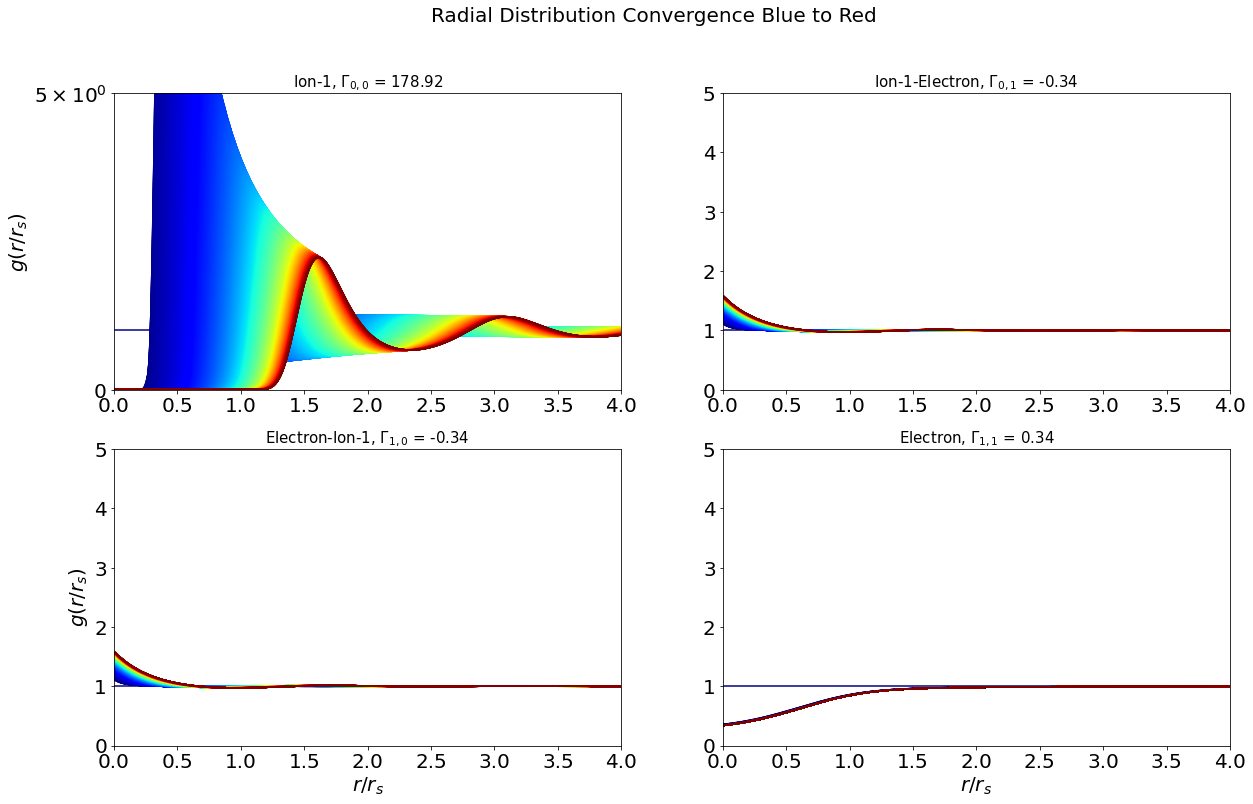

In [91]:
hydrogen_DW.plot_species_convergence_g(n_slices= int(len(hydrogen_DW.h_list)/1)  )

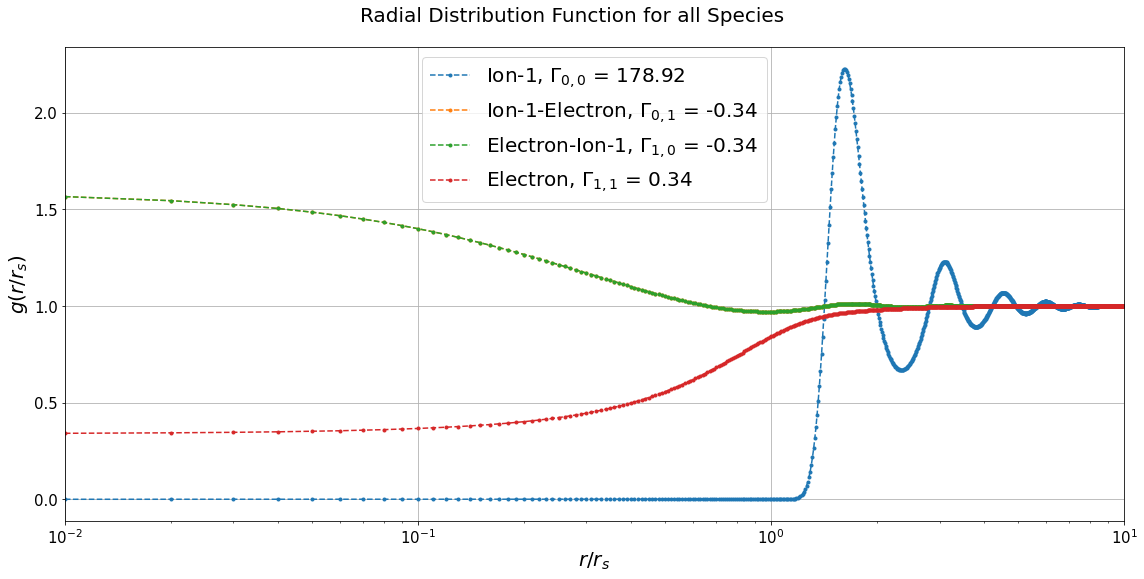

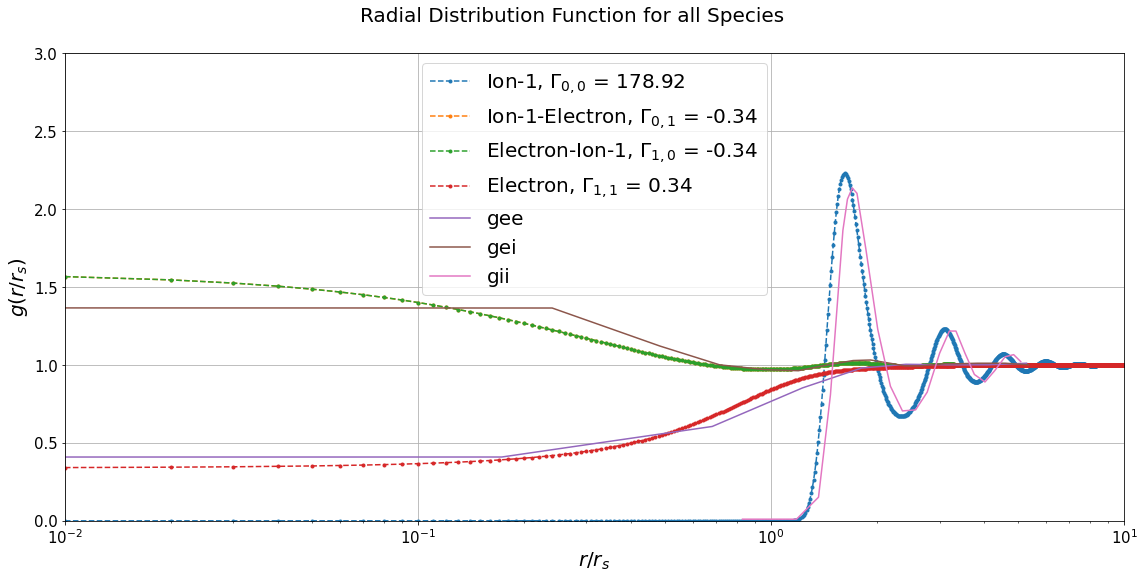

In [92]:
hydrogen_DW.plot_g_all_species()
hydrogen_DW.plot_g_all_species(gmax=3,data_to_compare=data_files, data_names=labels)


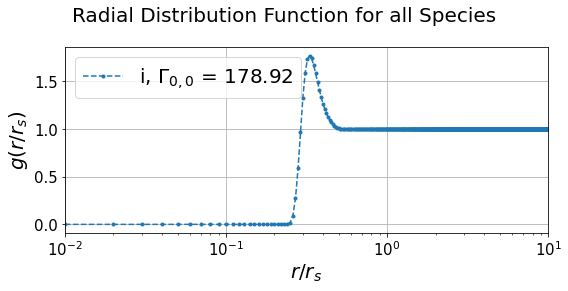

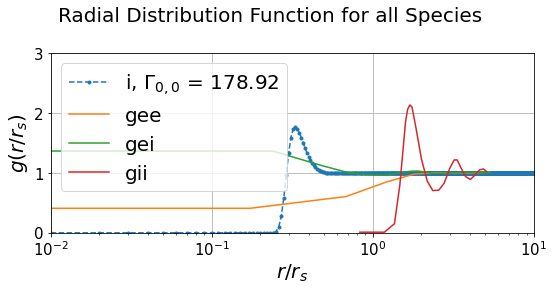

In [93]:
hydrogen_DW_one_species.plot_g_all_species()
hydrogen_DW_one_species.plot_g_all_species(gmax=3,data_to_compare=data_files, data_names=labels)


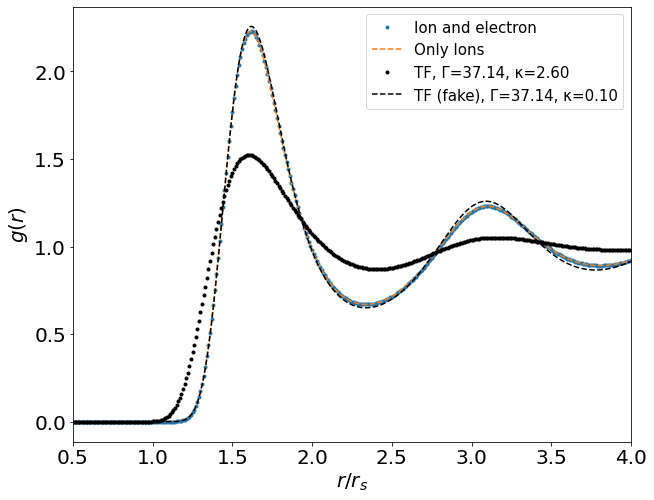

In [123]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(hydrogen_DW.r_array, hydrogen_DW.h_r_matrix[0,0]+1,'.', label='Ion and electron')
ax.plot(hydrogen_DW_one_species.r_array, hydrogen_DW_one_species.h_r_matrix[0,0]+1, '--',label="Only Ions")

ax.plot(hydrogen_TF.r_array, hydrogen_TF.h_r_matrix[0,0]+1,'k.',label='TF, Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, κ))
ax.plot(hydrogen_TF_fake.r_array, hydrogen_TF_fake.h_r_matrix[0,0]+1,'k--',label='TF (fake), Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, fake_κ))


ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
ax.legend(fontsize=15)


In [125]:
hydrogen_DW_qsp.Γei

-0.3384387646638051